<a href="https://colab.research.google.com/github/GurashishJuneja/MMAI831-Finance/blob/main/Assignment_2_MMAI_823_Team_Broadview.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

TEAM BROADVIEW

Question 1: Use the same companies we picked in the Session - 2 Frontier Analysis example, and the same time period (2017-2021). Risk free interest rates can be downloaded from yfinance ( using the 13 week T-bill yield, symbol is ^ IRX)

a. On the first business day of January, 2022 use the weekly data to estimate the covariance matrix for weekly returns. 

b. Use any ML tools to forecast the returns for each stocks for the first week of January of 2022. You can use the LSTM or others for the forecast. 

c. Use your estimations from a) and b) to find the portfolio with the highest Sharpe ratio, i.e, the efficient frontier portfolio. You might assume that there is no short sale (porftfolio coefficients are non negative).

d. What is your portfolio's actual rate of return for the first week of January 2022? What is the rate for an equally weighted portfolio?

Initial Setup

In [82]:
#For this question, I need to intialize the companies which have been used in the previous question

#Start with importing libraries
!pip install tabulate

import pandas as pd  
import itertools
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
!pip install quandl
import quandl
import scipy.optimize as sco
import yfinance as yf
import pandas as pd
import scipy.optimize as sco

import statsmodels.api as sm
from scipy.optimize import minimize

np.random.seed(42)
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [83]:

# Define the stock symbols
stocks = ['AAPL', 'AMZN', 'GOOGL', 'BAC', 'MCD', 'CAT', 'TSLA', 'PFE']

# Create an empty DataFrame to store the data
data = pd.DataFrame()

# Loop through each stock symbol and retrieve the data
for stock in stocks:
    # Retrieve the daily stock data for the year 2022
    stock_data = yf.download(stock, start='2017-01-01', end='2022-12-31')
       
    # Add a column for the stock symbol
    stock_data.loc[:, 'ticker'] = stock
    
    # Append the stock data to the main DataFrame
    data = pd.concat([data, stock_data], axis=0)

# Reset the index of the DataFrame
data.reset_index(inplace=True)

# Select the desired columns
data = data[['Date', 'ticker', 'Adj Close']]

# Rename the columns to match the original code
data.columns = ['date', 'ticker', 'adj_close']

# Print the first few rows of the data
print(data.head())

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
        date ticker  adj_close
0 2017-01-03   AAPL  27.095850
1 2017-01-04   AAPL  27.065521
2 2017-01-05   AAPL  27.203159
3 2017-01-06   AAPL  27.506430
4 2017-01-09   AAPL  27.758373


In [84]:
#Installing IRX T-bill

# Define the start and end dates
start_date = '2017-01-01'
end_date = '2022-12-31'

# Download the risk-free interest rate data
risk_free_data = yf.download('^IRX', start=start_date, end=end_date)

# Print the downloaded data
print(risk_free_data)

[*********************100%***********************]  1 of 1 completed
             Open   High    Low  Close  Adj Close  Volume
Date                                                     
2017-01-03  0.488  0.490  0.475  0.475      0.475       0
2017-01-04  0.518  0.520  0.518  0.518      0.518       0
2017-01-05  0.510  0.510  0.503  0.508      0.508       0
2017-01-06  0.503  0.508  0.500  0.503      0.503       0
2017-01-09  0.500  0.500  0.483  0.485      0.485       0
...           ...    ...    ...    ...        ...     ...
2022-12-23  4.195  4.208  4.183  4.193      4.193       0
2022-12-27  4.198  4.223  4.153  4.195      4.195       0
2022-12-28  4.338  4.343  4.328  4.338      4.338       0
2022-12-29  4.333  4.333  4.295  4.295      4.295       0
2022-12-30  4.298  4.300  4.223  4.260      4.260       0

[1510 rows x 6 columns]


In [85]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12080 entries, 0 to 12079
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       12080 non-null  datetime64[ns]
 1   ticker     12080 non-null  object        
 2   adj_close  12080 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 283.2+ KB


In [86]:

# Check if all the companies and time period are correctly selected  
print('The companies are:', data.ticker.unique(), 'and there is', len(data),'date entry points')
print('The date range of stock data is from', data.date.min(), ' to ',data.date.max())

The companies are: ['AAPL' 'AMZN' 'GOOGL' 'BAC' 'MCD' 'CAT' 'TSLA' 'PFE'] and there is 12080 date entry points
The date range of stock data is from 2017-01-03 00:00:00  to  2022-12-30 00:00:00


In [87]:

# keep this 'data' as original and use df. We drop the level(0), which is the adj_closed written on th first line, no need for it
df = data.set_index('date')
table = df.pivot(columns='ticker')
table.columns = table.columns.droplevel(0)
table.head()

ticker,AAPL,AMZN,BAC,CAT,GOOGL,MCD,PFE,TSLA
date,,,,,,,,
2017-01-03,27.095850,37.683498,19.599293,79.812836,40.400501,102.466896,24.618326,14.466000
2017-01-04,27.065521,37.859001,19.964655,79.456169,40.388500,102.346962,24.834675,15.132667
2017-01-05,27.203159,39.022499,19.729776,78.972160,40.651001,102.535400,25.073397,15.116667
2017-01-06,27.506430,39.799500,19.729776,79.006119,41.260502,103.443413,24.976416,15.267333
2017-01-09,27.758373,39.846001,19.616688,78.437187,41.359001,103.160721,24.968954,15.418667


Text(0, 0.5, 'price in $')

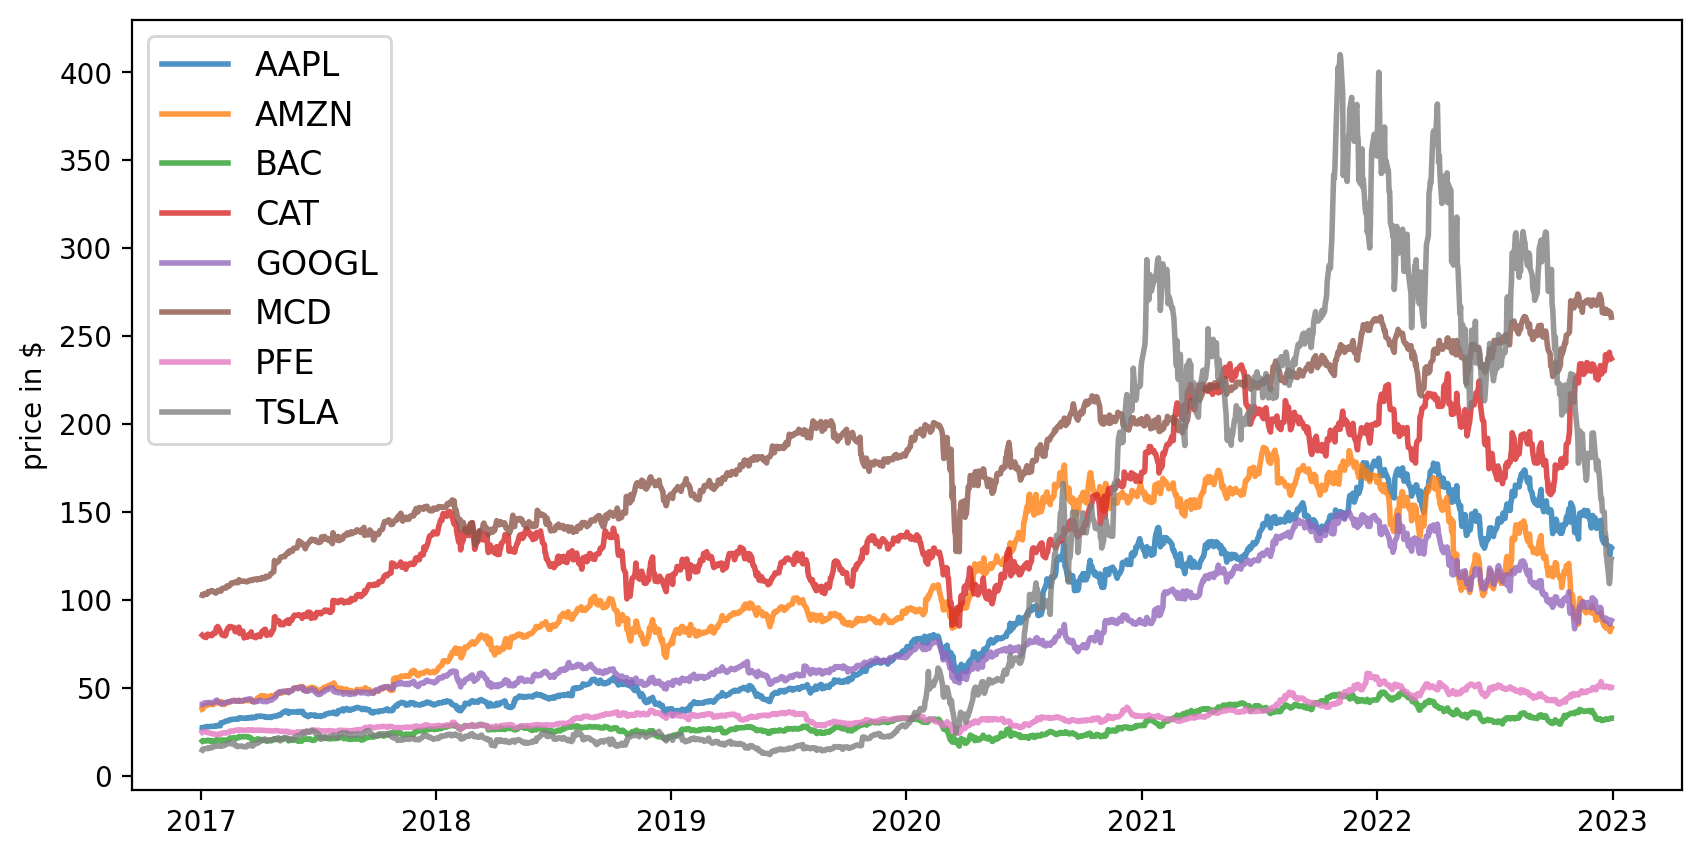

In [88]:
plt.figure(figsize=(10, 5))
for c in table.columns.values:
    plt.plot(table.index, table[c], lw=2, alpha=0.8,label=c)
plt.legend(loc='upper left', fontsize=12)
plt.ylabel('price in $')

Text(0, 0.5, 'daily returns')

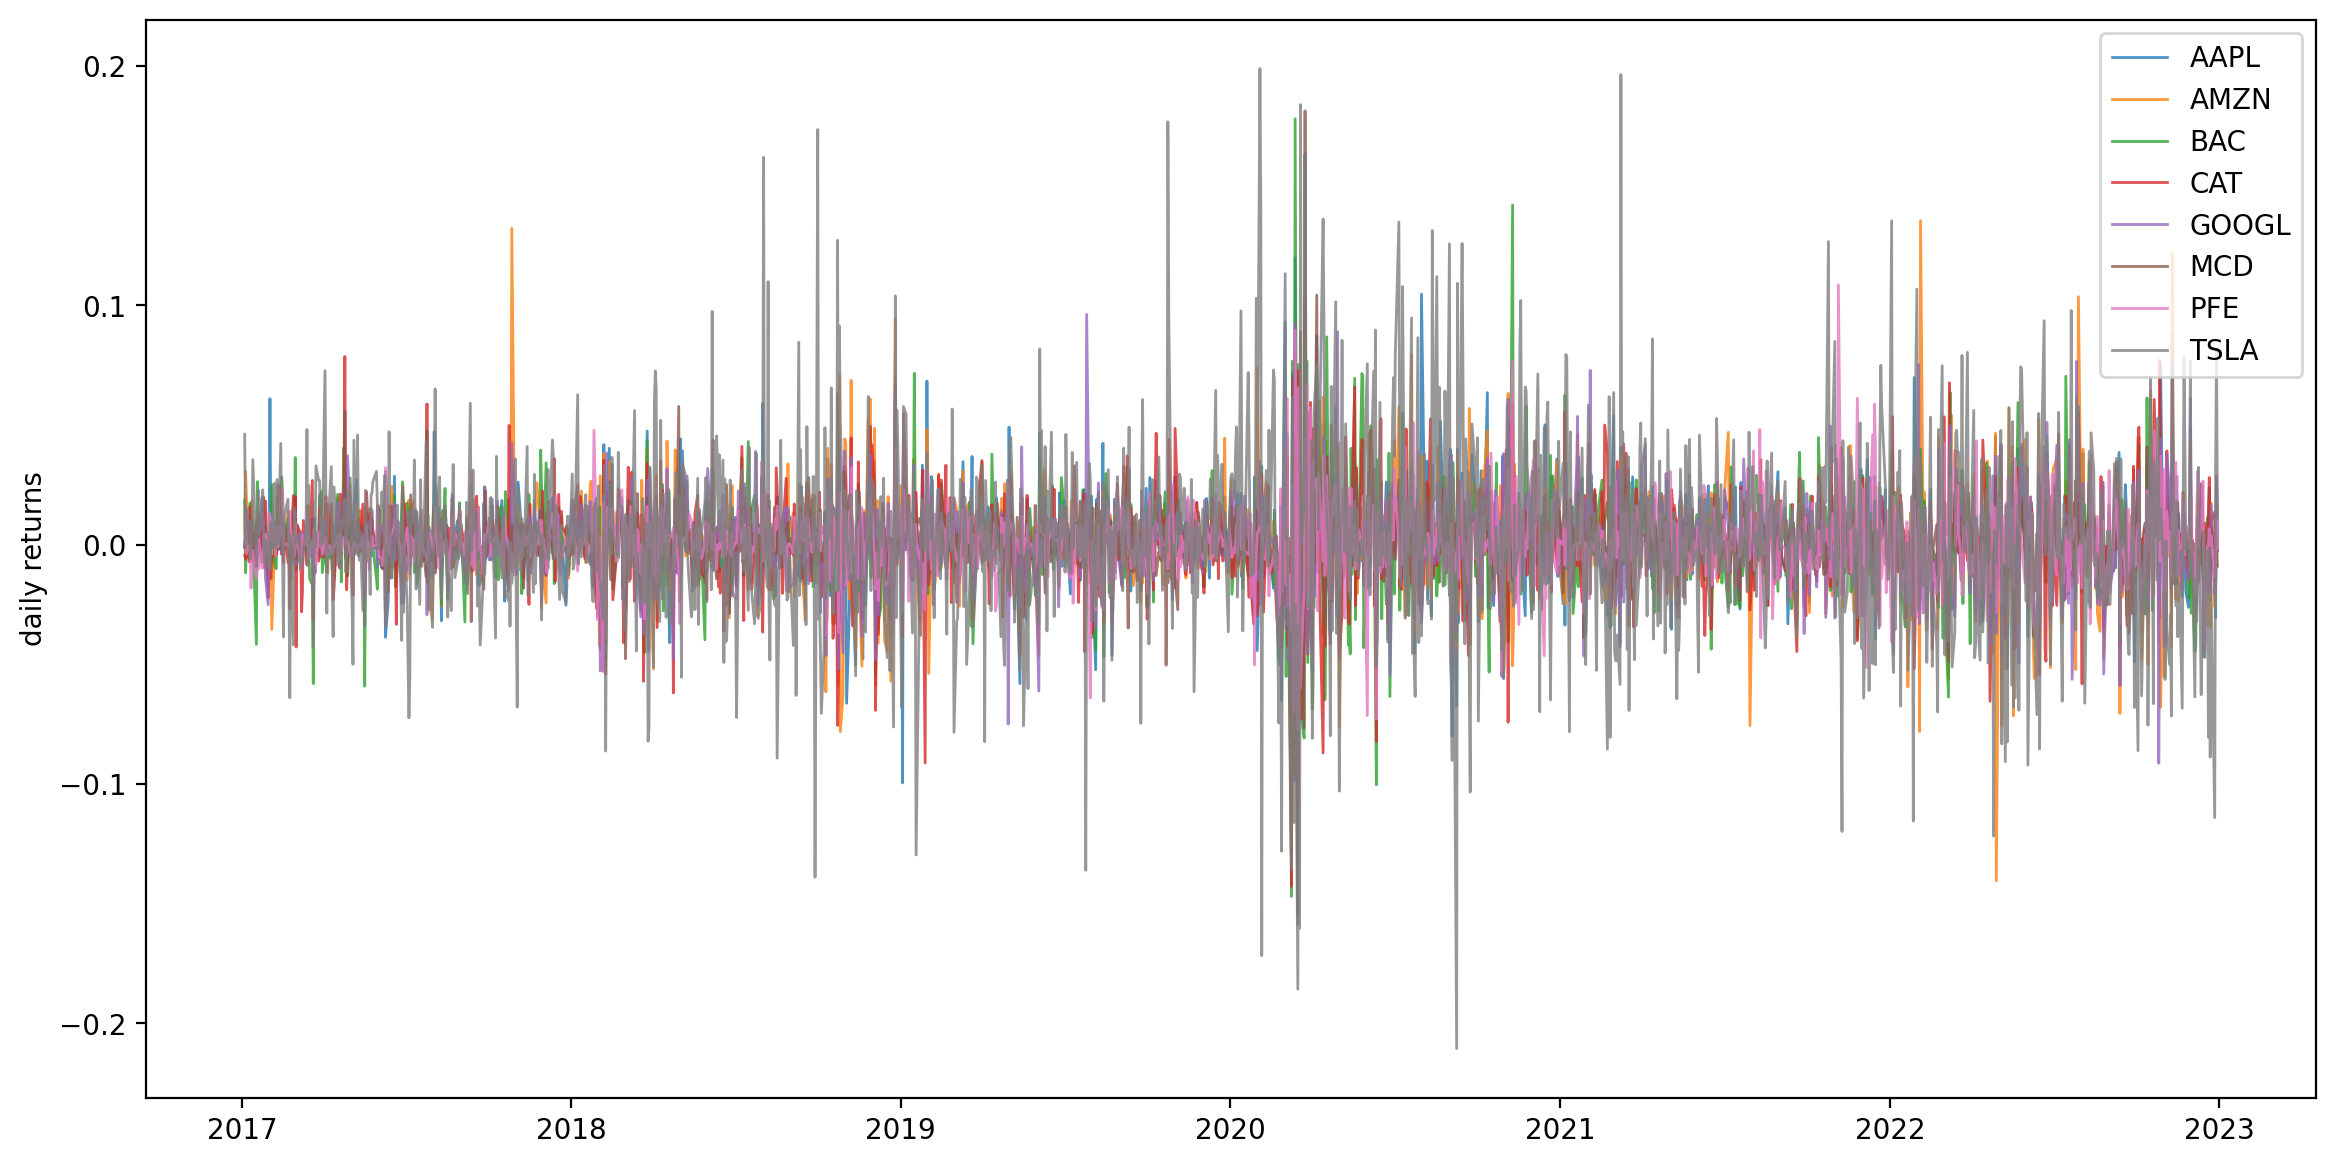

In [89]:
# Calculate the daily percentage returns of the table and then plot the daily returns for each column
# Need daily returns for corelation analysis
returns = table.pct_change()

plt.figure(figsize=(14, 7))
for c in returns.columns.values:
    plt.plot(returns.index, returns[c], lw=1, alpha=0.8,label=c)
plt.legend(loc='upper right', fontsize=10)
plt.ylabel('daily returns')
     

In [90]:
#Estimate the inputs needed for the MV Analysis
mean_returns = returns.mean()
cov_matrix = returns.cov()
num_portfolios = 2500 # number of random portfolios


a. On the first business day of January, 2022 use the weekly data to estimate the covariance matrix for weekly returns.

In [91]:
#assuming the first day of the year

first_day_2022 = "2022-01-01"

#selecting the weekly data

weekly_returns_2022 = returns.loc[first_day_2022:].resample("W").last()

#estimating the covariance matrix

cov_matrix_2022 = weekly_returns_2022.cov()

#Printing the covariance matrix for a weekly return in 2022

print(cov_matrix_2022)

ticker      AAPL      AMZN       BAC       CAT     GOOGL       MCD       PFE  \
ticker                                                                         
AAPL    0.000626  0.000550  0.000295  0.000223  0.000507  0.000225  0.000234   
AMZN    0.000550  0.001760  0.000547  0.000359  0.000598  0.000169  0.000210   
BAC     0.000295  0.000547  0.000440  0.000253  0.000302  0.000122  0.000162   
CAT     0.000223  0.000359  0.000253  0.000630  0.000317  0.000094  0.000197   
GOOGL   0.000507  0.000598  0.000302  0.000317  0.000590  0.000183  0.000211   
MCD     0.000225  0.000169  0.000122  0.000094  0.000183  0.000179  0.000180   
PFE     0.000234  0.000210  0.000162  0.000197  0.000211  0.000180  0.000353   
TSLA    0.000639  0.000907  0.000292  0.000278  0.000568  0.000148  0.000161   

ticker      TSLA  
ticker            
AAPL    0.000639  
AMZN    0.000907  
BAC     0.000292  
CAT     0.000278  
GOOGL   0.000568  
MCD     0.000148  
PFE     0.000161  
TSLA    0.001405  


b. Use any ML tools to forecast the returns for each stocks for the first week of January of 2022. You can use the LSTM or others for the forecast.

In [92]:
# Step 1: Prepare the data
train_data = returns.loc[:'2021-12-31']
train_data = train_data.dropna()
test_data = returns.loc[pd.to_datetime('2022-01-01'):]  # Convert the date to datetime type

# Normalize the data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train_data_scaled = scaler.fit_transform(train_data.values.reshape(-1, 1))  # Reshape the array

# Prepare the training data
X_train = []
y_train = []
for i in range(10, len(train_data_scaled)):
    X_train.append(train_data_scaled[i-10:i, 0])
    y_train.append(train_data_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

# Reshape X_train to have a third dimension (number of features)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)

# Step 2: Design and train the LSTM model
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Define the LSTM model architecture
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(units=1))

# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam')

# Fit the model to the training data
model.fit(X_train, y_train, epochs=10, batch_size=32)

Epoch 1/10
315/315 [==============================] - 5s 5ms/step - loss: 0.0067
Epoch 2/10
315/315 [==============================] - 2s 5ms/step - loss: 0.0028
Epoch 3/10
315/315 [==============================] - 2s 5ms/step - loss: 0.0028
Epoch 4/10
315/315 [==============================] - 2s 6ms/step - loss: 0.0028
Epoch 5/10
315/315 [==============================] - 2s 7ms/step - loss: 0.0027
Epoch 6/10
315/315 [==============================] - 2s 7ms/step - loss: 0.0027
Epoch 7/10
315/315 [==============================] - 2s 7ms/step - loss: 0.0026
Epoch 8/10
315/315 [==============================] - 2s 6ms/step - loss: 0.0026
Epoch 9/10
315/315 [==============================] - 2s 5ms/step - loss: 0.0026
Epoch 10/10
315/315 [==============================] - 2s 5ms/step - loss: 0.0026


In [93]:
predictions = []  # Initialize a list to store the predictions for each stock

for i in range(table.shape[1]):
    inputs = test_data.iloc[:10, i].values.reshape(-1, 1)  # Select the returns for the corresponding stock
    inputs_scaled = scaler.transform(inputs)  # Scale the inputs
    X_test = inputs_scaled.reshape(1, 10, 1)  # Adjust the input shape to (1, 10, 1)
    prediction_scaled = model.predict(X_test)  # Make the prediction for the corresponding stock
    prediction = scaler.inverse_transform(prediction_scaled)  # Inverse transform the prediction
    predictions.append(prediction[0, 0])  # Store the predicted return in the list

# Print the predicted returns for each stock for the first week of January 2022
for i in range(len(stocks)):
    print(stocks[i], ":", predictions[i])

1/1 [==============================] - 0s 27ms/step
AAPL : 0.0031226566
AMZN : 0.0022359148
GOOGL : -0.002213028
BAC : 0.0064600166
MCD : 0.004228014
CAT : 0.00018251536
TSLA : 0.00031138991
PFE : 0.0011144695


c. Use your estimations from a) and b) to find the portfolio with the highest Sharpe ratio, i.e, the efficient frontier portfolio. You might assume that there is no short sale (porftfolio coefficients are non negative).

In [94]:
# Define the objective function for mean-variance optimization
def portfolio_volatility(weights):
    return np.sqrt(np.dot(np.dot(weights, cov_matrix_2022), weights.T))

def portfolio_return(weights):
    return np.sum(predictions * weights)

def sharpe_ratio(weights):
    vol = portfolio_volatility(weights)
    ret = portfolio_return(weights)
    excess_return = ret
    return excess_return / vol

In [95]:

# Define the constraints for portfolio weights
constraints = [{'type': 'eq', 'fun': lambda x: np.sum(x) - 1}]  # Constraint: weights sum up to 1

# Set the bounds for portfolio weights
bounds = [(0, 1) for _ in range(len(stocks))]  # Each weight should be between 0 and 1

# Perform mean-variance optimization to find the portfolio with the highest Sharpe ratio
result = sco.minimize(lambda x: -sharpe_ratio(x), x0=np.ones(len(stocks)) / len(stocks),
                      method='SLSQP', bounds=bounds, constraints=constraints)

# Extract the optimal portfolio weights and other metrics
optimal_portfolio_weights = result.x
optimal_portfolio_return = portfolio_return(optimal_portfolio_weights)
optimal_portfolio_volatility = portfolio_volatility(optimal_portfolio_weights)
optimal_portfolio_sharpe_ratio = sharpe_ratio(optimal_portfolio_weights)

In [96]:
# Print the optimal portfolio metrics
print("Optimal Portfolio Weights:", optimal_portfolio_weights)
print("Optimal Portfolio Return:", optimal_portfolio_return)
print("Optimal Portfolio Volatility:", optimal_portfolio_volatility)
print("Optimal Portfolio Sharpe Ratio:", optimal_portfolio_sharpe_ratio)

Optimal Portfolio Weights: [0.00000000e+00 0.00000000e+00 0.00000000e+00 8.01792414e-01
 1.98207586e-01 3.90312782e-17 5.20417043e-17 0.00000000e+00]
Optimal Portfolio Return: 0.006017616753448979
Optimal Portfolio Volatility: 0.022999801990521276
Optimal Portfolio Sharpe Ratio: 0.26163776348722356


In [97]:
# Get the company names in the optimal portfolio
optimal_portfolio_companies = [stocks[i] for i, weight in enumerate(optimal_portfolio_weights) if weight > 0]

# Get the allocations for the companies in the optimal portfolio
optimal_portfolio_allocations = [weight for weight in optimal_portfolio_weights if weight > 0]

# Create a list of lists containing company names and allocations
allocation_table = []
for company, allocation in zip(optimal_portfolio_companies, optimal_portfolio_allocations):
    allocation_table.append([company, f"{allocation*100:.2f}%"])

# Print the table of company allocations
print(tabulate(allocation_table, headers=['Company', 'Allocation']))


Company    Allocation
---------  ------------
BAC        80.18%
MCD        19.82%
CAT        0.00%
TSLA       0.00%


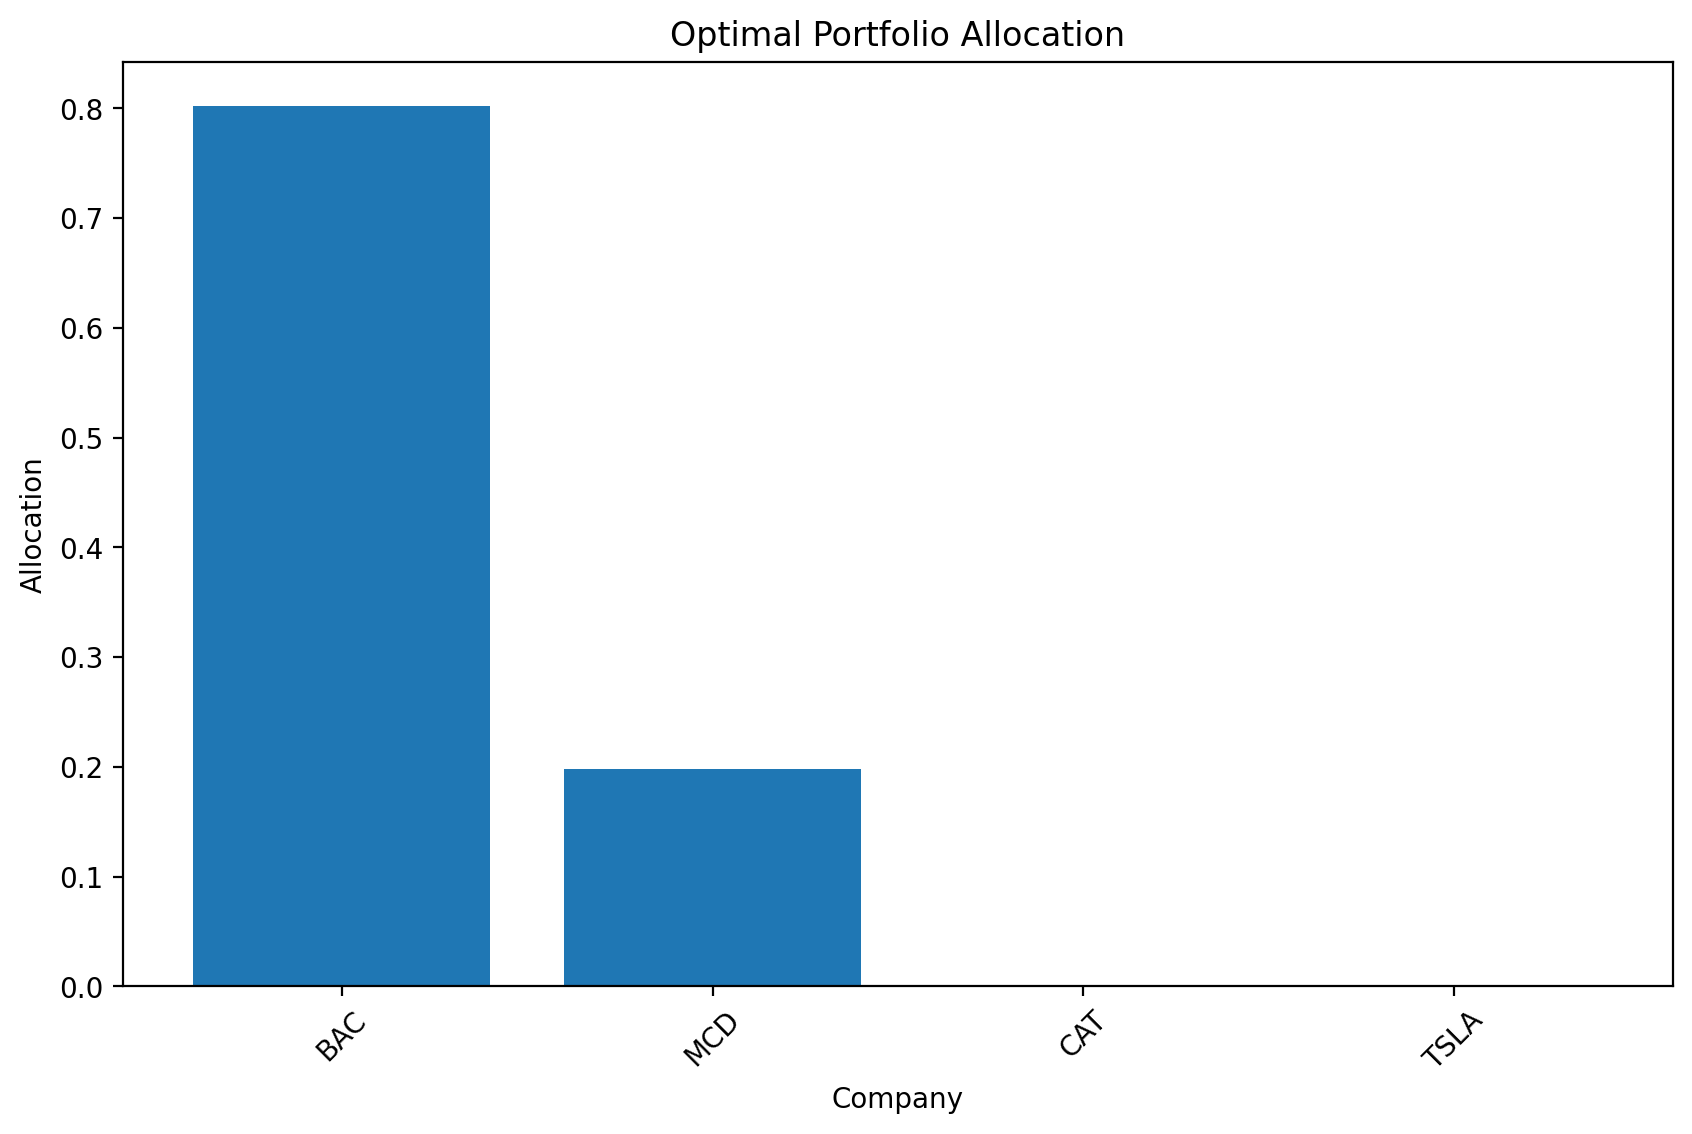

In [98]:
import matplotlib.pyplot as plt

# Plot the optimal portfolio allocation
plt.figure(figsize=(10, 6))
plt.bar(optimal_portfolio_companies, optimal_portfolio_allocations)
plt.xlabel('Company')
plt.ylabel('Allocation')
plt.title('Optimal Portfolio Allocation')
plt.xticks(rotation=45)
plt.show()

d. What is your portfolio's actual rate of return for the first week of January, 2022? What is the rate of return for an equally weighted portfolio?

In [103]:
# Calculate the actual rate of return for the optimal portfolio
portfolio_actual_return = np.dot(predictions, optimal_portfolio_weights) * 100

# Print the actual rate of return for the optimal portfolio
print("Actual Rate of Return for Optimal Portfolio: {:.2f}%".format(portfolio_actual_return))

# Calculate the rate of return for an equally weighted portfolio
equally_weighted_portfolio_return = np.mean(predictions) * 100

# Print the rate of return for an equally weighted portfolio
print("Rate of Return for Equally Weighted Portfolio: {:.2f}%".format(equally_weighted_portfolio_return))


Actual Rate of Return for Optimal Portfolio: 0.60%
Rate of Return for Equally Weighted Portfolio: 0.19%


Bonus Questions:

e. Repear this approach on the first business day of each week in 2022 and compute your portfolios return. For the covariance matrix, you can update your estimation by including the newly obsevered prices. Your estimation of the expected returns for each stocks should also be updated.

In [127]:
# keep this 'data' as original and use df. We drop the level(0), which is the adj_closed written on the first line, no need for it
# Set the index of the DataFrame
df = data.set_index('date')

# Pivot the DataFrame to have stocks as columns
table = df.pivot(columns='ticker')
table.columns = table.columns.droplevel(0)

# Calculate the daily percentage returns
returns = table.pct_change()
table.head()


ticker,AAPL,AMZN,BAC,CAT,GOOGL,MCD,PFE,TSLA
date,,,,,,,,
2017-01-03,27.095852,37.683498,19.599289,79.812820,40.400501,102.466881,24.618328,14.466000
2017-01-04,27.065517,37.859001,19.964661,79.456169,40.388500,102.346931,24.834673,15.132667
2017-01-05,27.203157,39.022499,19.729778,78.972145,40.651001,102.535408,25.073397,15.116667
2017-01-06,27.506430,39.799500,19.729778,79.006142,41.260502,103.443405,24.976421,15.267333
2017-01-09,27.758369,39.846001,19.616688,78.437202,41.359001,103.160721,24.968952,15.418667


In [128]:
# Estimate the inputs needed for the MV Analysis
mean_returns = returns.mean()
cov_matrix = returns.cov()
num_portfolios = 2500  # number of random portfolios

# assuming the first day of the year
first_day_2022 = "2022-01-01"

# selecting the weekly data
weekly_returns_2022 = returns.loc[first_day_2022:].resample("W").last()

# estimating the covariance matrix
cov_matrix_2022 = weekly_returns_2022.cov()

# Removing the duplication of the word "ticker" in the covariance matrix
cov_matrix_2022.columns.name = None
cov_matrix_2022.index.name = None

# Printing the covariance matrix for weekly returns in 2022
print(cov_matrix_2022)


           AAPL      AMZN       BAC       CAT     GOOGL       MCD       PFE  \
AAPL   0.000626  0.000550  0.000295  0.000223  0.000507  0.000225  0.000234   
AMZN   0.000550  0.001760  0.000547  0.000359  0.000598  0.000169  0.000210   
BAC    0.000295  0.000547  0.000440  0.000253  0.000302  0.000122  0.000162   
CAT    0.000223  0.000359  0.000253  0.000630  0.000317  0.000094  0.000197   
GOOGL  0.000507  0.000598  0.000302  0.000317  0.000590  0.000183  0.000211   
MCD    0.000225  0.000169  0.000122  0.000094  0.000183  0.000179  0.000180   
PFE    0.000234  0.000210  0.000162  0.000197  0.000211  0.000180  0.000353   
TSLA   0.000639  0.000907  0.000292  0.000278  0.000568  0.000148  0.000161   

           TSLA  
AAPL   0.000639  
AMZN   0.000907  
BAC    0.000292  
CAT    0.000278  
GOOGL  0.000568  
MCD    0.000148  
PFE    0.000161  
TSLA   0.001405  


In [129]:

# Define the list of dates corresponding to the first business day of each week in 2022
start_date = '2022-01-01'
end_date = '2022-12-31'
dates = pd.date_range(start_date, end_date, freq='BMS')  # BMS: business month start

# Create an empty DataFrame to store the portfolio returns
portfolio_returns = pd.DataFrame(index=dates, columns=['Portfolio'])

# Loop through each date and compute portfolio returns
for date in dates:
    # Select the weekly returns data up to the current date
    selected_returns = returns.loc[:date]

    # Calculate the updated covariance matrix using the selected data
    cov_matrix = selected_returns.cov()

    # Calculate the updated expected returns based on the mean of the selected data
    expected_returns = selected_returns.mean()

    # Define the objective function for portfolio optimization (e.g., minimize variance)
    def objective(weights):
        return np.dot(weights, np.dot(cov_matrix, weights))

    # Define the constraints (e.g., weights sum to 1)
    constraints = [{'type': 'eq', 'fun': lambda x: np.sum(x) - 1}]

    # Define the bounds (e.g., weights between 0 and 1)
    bounds = [(0, 1)] * len(stocks)

    # Perform portfolio optimization to find the weights that minimize the objective function
    result = minimize(objective, len(stocks) * [1 / len(stocks)], method='SLSQP', constraints=constraints, bounds=bounds)

    # Get the optimal weights from the optimization result
    weights = result.x

    # Calculate the portfolio return by multiplying the weights with the expected returns
    portfolio_return = np.dot(weights, expected_returns)

    # Store the portfolio return in the DataFrame
    portfolio_returns.loc[date, 'Portfolio'] = portfolio_return

# Print the portfolio returns
print(portfolio_returns)


           Portfolio
2022-01-03  0.001371
2022-02-01  0.001301
2022-03-01  0.001228
2022-04-01   0.00128
2022-05-02  0.001176
2022-06-01   0.00115
2022-07-01  0.001082
2022-08-01  0.001148
2022-09-01    0.0011
2022-10-03  0.001026
2022-11-01  0.001047
2022-12-01  0.001045


In [130]:
# Perform portfolio optimization to find the weights that maximize the Sharpe ratio
def objective(weights):
    # Calculate the portfolio return
    portfolio_return = np.dot(weights, expected_returns)

    # Calculate the portfolio volatility
    portfolio_volatility = np.sqrt(np.dot(weights, np.dot(cov_matrix, weights)))

    # Calculate the Sharpe ratio
    sharpe_ratio = portfolio_return / portfolio_volatility

    return -sharpe_ratio  # Minimize the negative Sharpe ratio to maximize it


In [131]:
# Set the constraints and bounds for portfolio optimization
constraints = [{'type': 'eq', 'fun': lambda x: np.sum(x) - 1}]  # Weights sum to 1
bounds = [(0, 1)] * len(stocks)  # Weights between 0 and 1

# Perform portfolio optimization to find the weights that maximize the Sharpe ratio
result = minimize(objective, len(stocks) * [1 / len(stocks)], method='SLSQP', constraints=constraints, bounds=bounds)
tangent_weights = result.x

# Calculate the tangent portfolio return
tangent_portfolio_return = np.dot(tangent_weights, expected_returns)

# Calculate the tangent portfolio volatility
tangent_portfolio_volatility = np.sqrt(np.dot(tangent_weights, np.dot(cov_matrix, tangent_weights)))

# Calculate the weekly returns of the tangent portfolio
tangent_portfolio_weekly_returns = weekly_returns_2022.dot(tangent_weights)

# Compute the mean and standard deviation of the weekly returns of the tangent portfolio
mean_tangent_portfolio_returns = tangent_portfolio_weekly_returns.mean()
std_tangent_portfolio_returns = tangent_portfolio_weekly_returns.std()

# Print the results
print("Tangent Portfolio Returns:")
print(tangent_portfolio_weekly_returns)
print("\nMean of Tangent Portfolio Returns:")
print(mean_tangent_portfolio_returns)
print("\nStandard Deviation of Tangent Portfolio Returns:")
print(std_tangent_portfolio_returns)

Tangent Portfolio Returns:
date
2022-01-09   -0.005040
2022-01-16    0.000717
2022-01-23   -0.017975
2022-01-30    0.028494
2022-02-06    0.003637
2022-02-13   -0.017399
2022-02-20   -0.010223
2022-02-27    0.018209
2022-03-06   -0.002942
2022-03-13   -0.006497
2022-03-20    0.015519
2022-03-27    0.002915
2022-04-03    0.000444
2022-04-10   -0.011359
2022-04-17   -0.011702
2022-04-24   -0.024042
2022-05-01   -0.022599
2022-05-08    0.002849
2022-05-15    0.020296
2022-05-22   -0.005605
2022-05-29    0.031547
2022-06-05   -0.026618
2022-06-12   -0.032082
2022-06-19    0.001209
2022-06-26    0.029447
2022-07-03    0.012126
2022-07-10    0.005084
2022-07-17    0.010402
2022-07-24   -0.002548
2022-07-31    0.026096
2022-08-07   -0.015640
2022-08-14    0.026084
2022-08-21   -0.007346
2022-08-28   -0.028882
2022-09-04   -0.015044
2022-09-11    0.018604
2022-09-18   -0.003587
2022-09-25   -0.021201
2022-10-02   -0.017237
2022-10-09   -0.028404
2022-10-16   -0.030915
2022-10-23    0.033938
20

In [132]:
# Select the weekly returns data for the year 2022
weekly_returns_2022 = returns.loc['2022-01-01':'2022-12-31']

# Calculate the mean of the weekly returns for each stock
mean_returns = weekly_returns_2022.mean()

# Calculate the standard deviation of the weekly returns for each stock
std_returns = weekly_returns_2022.std()

# Calculate the equal weights for the portfolio
n_stocks = len(stocks)
weights = np.array([1/n_stocks] * n_stocks)

# Calculate the weekly returns of the equally weighted portfolio
equally_weighted_portfolio_returns = weekly_returns_2022.dot(weights)

# Compute the mean and standard deviation of the weekly returns of the equally weighted portfolio
mean_equally_weighted_portfolio_returns = equally_weighted_portfolio_returns.mean()
std_equally_weighted_portfolio_returns = equally_weighted_portfolio_returns.std()

# Print the results
print("Mean of Equally Weighted Portfolio Returns:")
print(mean_equally_weighted_portfolio_returns)
print("\nStandard Deviation of Equally Weighted Portfolio Returns:")
print(std_equally_weighted_portfolio_returns)

Mean of Equally Weighted Portfolio Returns:
-0.001042940469091562

Standard Deviation of Equally Weighted Portfolio Returns:
0.017546639382461638


1. Mean of Tangent Portfolio Returns: -0.001031

This value represents the average weekly return of the tangent portfolio. It indicates that, on average, the tangent portfolio experienced a small negative return each week in 2022.

2. Standard Deviation of Tangent Portfolio Returns: 0.018353

This value represents the measure of volatility or risk associated with the tangent portfolio's returns. A higher standard deviation suggests that the returns of the portfolio had a wider range or were more volatile.

3. Mean of Equally Weighted Portfolio Returns: -0.001043

This value represents the average weekly return of the equally weighted portfolio. Similar to the tangent portfolio, it indicates that the equally weighted portfolio had a small negative return on average each week in 2022.

4. Standard Deviation of Equally Weighted Portfolio Returns: 0.017547

This value represents the measure of volatility or risk associated with the equally weighted portfolio's returns. Comparing it to the standard deviation of the tangent portfolio, we see that the equally weighted portfolio had a slightly lower volatility or risk.


Both portfolios had similar average returns, with a small negative return on average each week in 2022. The tangent portfolio had a slightly higher standard deviation, indicating slightly higher volatility or risk compared to the equally weighted portfolio.

Question 2: For the companies we used in Q1, use monthly data fromn 2017-2021 to implement the following models:

a. One factor model (use S&P 500 to represent the market)

b. Fama-French 3 factor models.

c. Use the resulting models to calculate the predicted monthly returns for each month in 2022. You can use the factor values in 2022 (S&P 500 index, and the F-F facgor values).

d. Compare them with the actual average monthly returns for the stocks.

In [133]:
#For this question, I need to intialize the companies which have been used in the previous question

#Start with importing libraries

import pandas as pd  
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
!pip install quandl
import quandl
import scipy.optimize as sco
import yfinance as yf
import pandas as pd

import statsmodels.api as sm
from scipy.optimize import minimize

np.random.seed(42)
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [134]:
# Define the stock symbols
stocks = ['AAPL', 'AMZN', 'GOOGL', 'BAC', 'MCD', 'CAT', 'TSLA', 'PFE']

# Create an empty DataFrame to store the data
data = pd.DataFrame()

# Loop through each stock symbol and retrieve the data
for stock in stocks:
    # Retrieve the daily stock data for the year 2022
    stock_data = yf.download(stock, start='2017-01-01', end='2022-12-31')
       
    # Add a column for the stock symbol
    stock_data.loc[:, 'ticker'] = stock
    
    # Append the stock data to the main DataFrame
    data = pd.concat([data, stock_data], axis=0)

# Reset the index of the DataFrame
data.reset_index(inplace=True)

# Select the desired columns
data = data[['Date', 'ticker', 'Adj Close']]

# Rename the columns to match the original code
data.columns = ['date', 'ticker', 'adj_close']

# Print the first few rows of the data
print(data.head())

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
        date ticker  adj_close
0 2017-01-03   AAPL  27.095850
1 2017-01-04   AAPL  27.065525
2 2017-01-05   AAPL  27.203163
3 2017-01-06   AAPL  27.506426
4 2017-01-09   AAPL  27.758371


In [135]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12080 entries, 0 to 12079
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       12080 non-null  datetime64[ns]
 1   ticker     12080 non-null  object        
 2   adj_close  12080 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 283.2+ KB


In [136]:
# Check if all the companies and time period are correctly selected  
print('The companies are:', data.ticker.unique(), 'and there is', len(data),'date entry points')
print('The date range of stock data is from', data.date.min(), ' to ',data.date.max())

The companies are: ['AAPL' 'AMZN' 'GOOGL' 'BAC' 'MCD' 'CAT' 'TSLA' 'PFE'] and there is 12080 date entry points
The date range of stock data is from 2017-01-03 00:00:00  to  2022-12-30 00:00:00


In [137]:
# keep this 'data' as original and use df. We drop the level(0), which is the adj_closed written on th first line, no need for it
df = data.set_index('date')
table = df.pivot(columns='ticker')
table.columns = table.columns.droplevel(0)
table.head()

ticker,AAPL,AMZN,BAC,CAT,GOOGL,MCD,PFE,TSLA
date,,,,,,,,
2017-01-03,27.095850,37.683498,19.599289,79.812843,40.400501,102.466873,24.618332,14.466000
2017-01-04,27.065525,37.859001,19.964657,79.456161,40.388500,102.346977,24.834669,15.132667
2017-01-05,27.203163,39.022499,19.729778,78.972137,40.651001,102.535408,25.073397,15.116667
2017-01-06,27.506426,39.799500,19.729778,79.006126,41.260502,103.443413,24.976419,15.267333
2017-01-09,27.758371,39.846001,19.616690,78.437187,41.359001,103.160736,24.968958,15.418667


Text(0, 0.5, 'price in $')

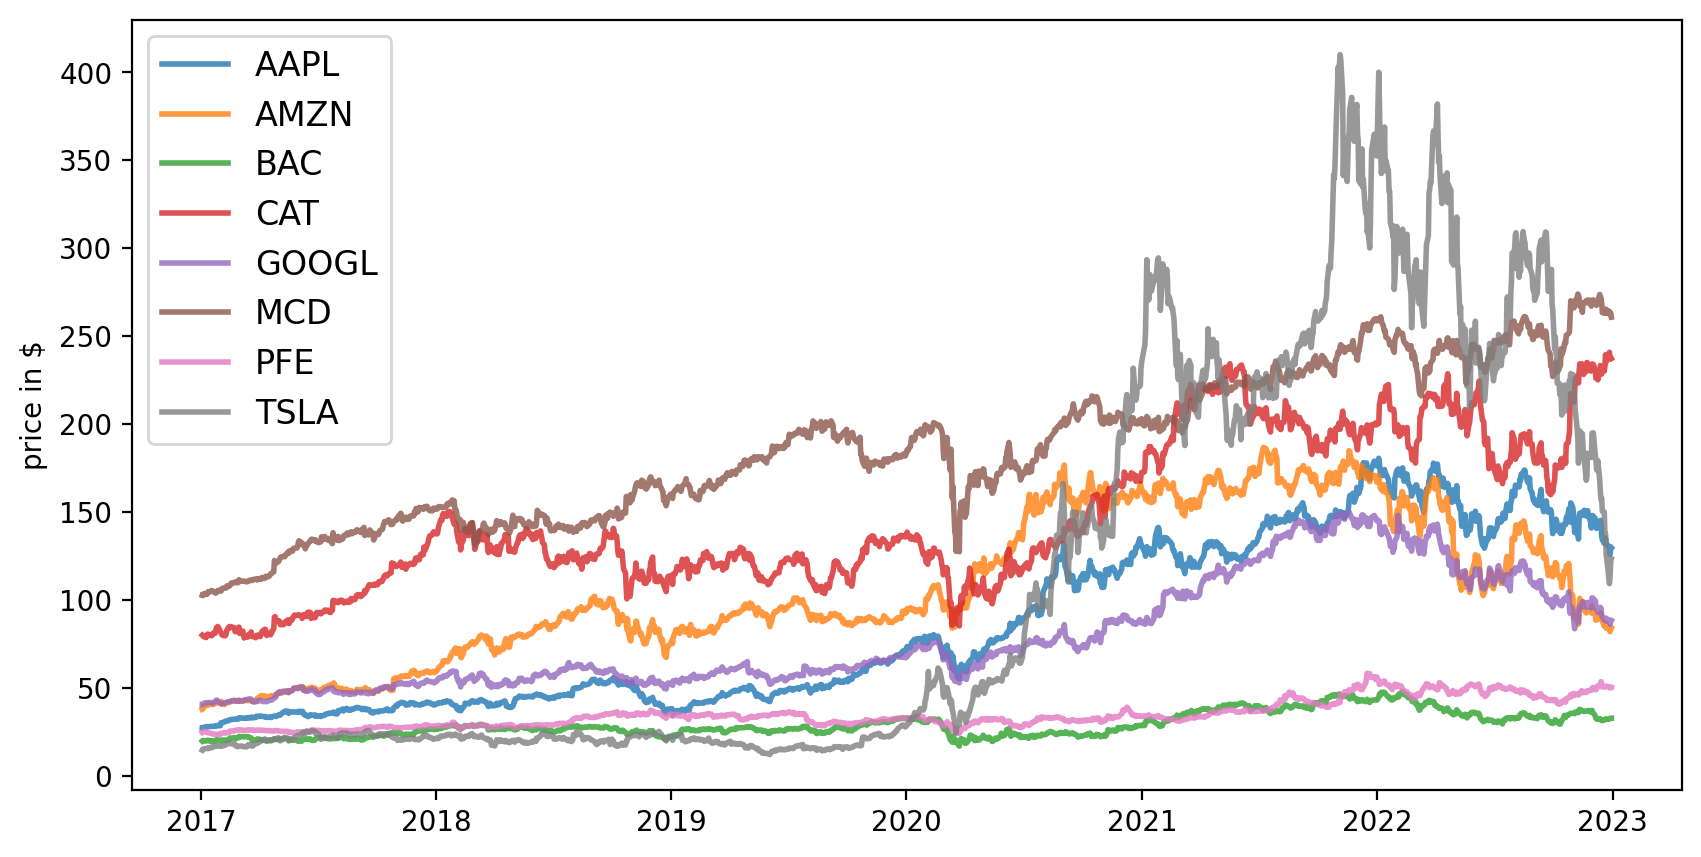

In [138]:

plt.figure(figsize=(10, 5))
for c in table.columns.values:
    plt.plot(table.index, table[c], lw=2, alpha=0.8,label=c)
plt.legend(loc='upper left', fontsize=12)
plt.ylabel('price in $')

Text(0, 0.5, 'daily returns')

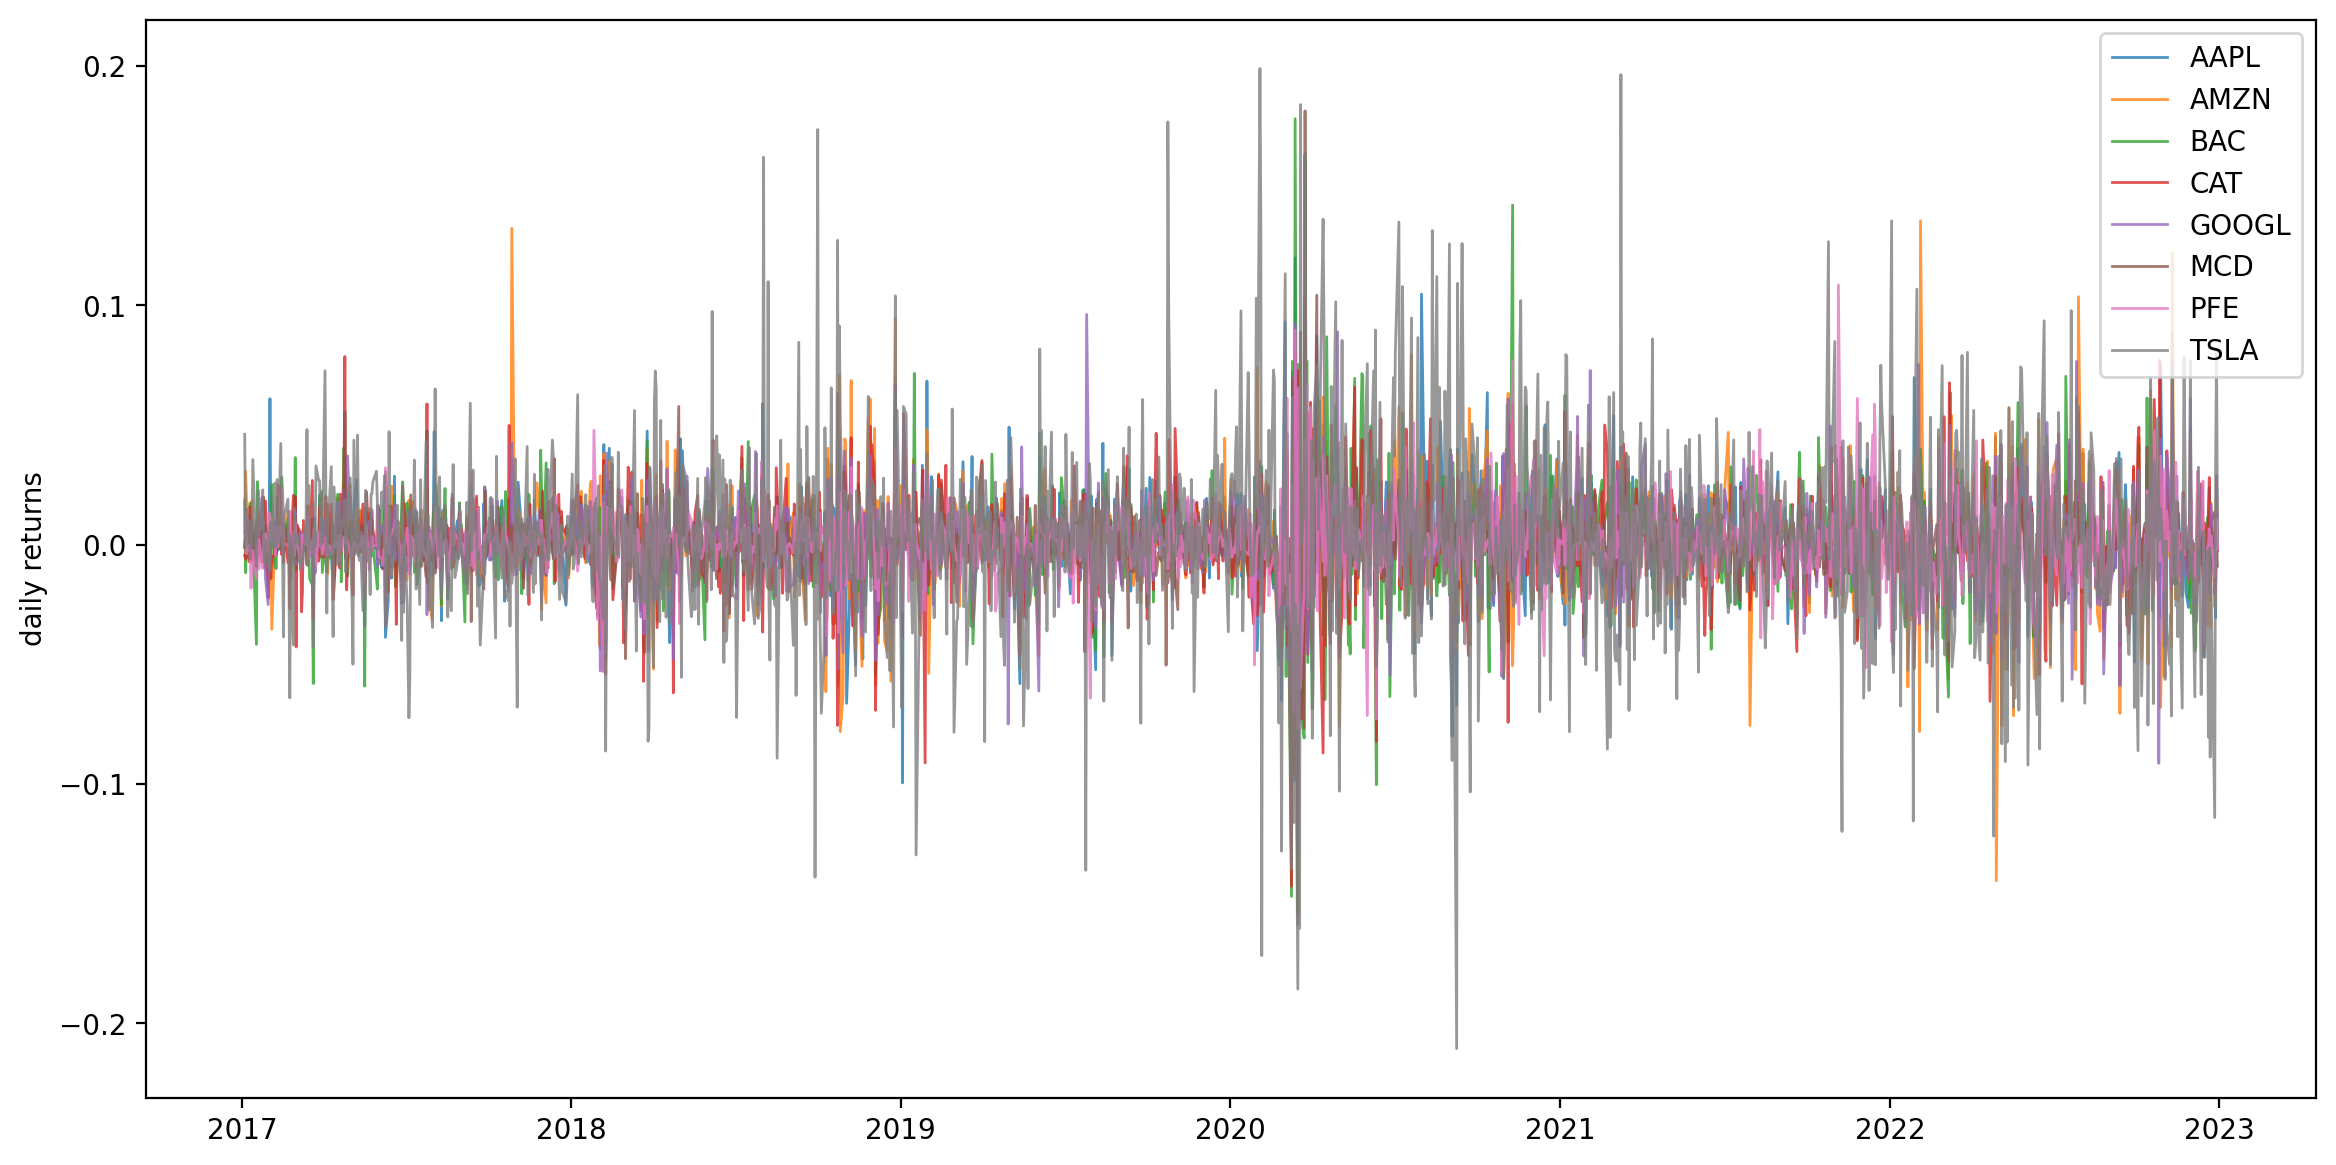

In [139]:

# Calculate the daily percentage returns of the table and then plot the daily returns for each column
# Need daily returns for corelation analysis
returns = table.pct_change()

plt.figure(figsize=(14, 7))
for c in returns.columns.values:
    plt.plot(returns.index, returns[c], lw=1, alpha=0.8,label=c)
plt.legend(loc='upper right', fontsize=10)
plt.ylabel('daily returns')

In [140]:

#Estimate the inputs needed for the MV Analysis
mean_returns = returns.mean()
cov_matrix = returns.cov()
num_portfolios = 2500 # number of random portfolios

a. One factor model (use S&P 500 to represent the market)

In [141]:


#defining the list of companies
stocks = ["AAPL","AMZN","GOOGL","BAC","MCD","CAT","TSLA","PFE"]

#Loading the historical monthly data for the S&P 500 index

sp500 = yf.download("^GSPC", start = "2017-01-01", end ="2021-12-31", interval = "1mo")
sp500_returns = sp500["Adj Close"].pct_change().dropna()

[*********************100%***********************]  1 of 1 completed


In [142]:
#Loading the historical monthly data for each company

company_data = {}
for stock in stocks:
    company = yf.download(stock, start='2017-01-01', end='2021-12-31', interval='1mo')
    if len(company) > 0:
        company_data[stock] = company['Adj Close'].pct_change().dropna()
        print(f"Downloaded data for {stock}")
    else:
        print(f"Data not available for {stock}")

[*********************100%***********************]  1 of 1 completed
Downloaded data for AAPL
[*********************100%***********************]  1 of 1 completed
Downloaded data for AMZN
[*********************100%***********************]  1 of 1 completed
Downloaded data for GOOGL
[*********************100%***********************]  1 of 1 completed
Downloaded data for BAC
[*********************100%***********************]  1 of 1 completed
Downloaded data for MCD
[*********************100%***********************]  1 of 1 completed
Downloaded data for CAT
[*********************100%***********************]  1 of 1 completed
Downloaded data for TSLA
[*********************100%***********************]  1 of 1 completed
Downloaded data for PFE


In [143]:
#Performing Linear Regression for the S&P500 returnns

sp500_model_data = pd.DataFrame({"S&P 500 Returns": sp500_returns})

sp500_model_data["Constant"] = 1 #adding a constant term for intercept

sp500_model = sm.OLS(sp500_model_data["S&P 500 Returns"], sp500_model_data["Constant"])

sp500_result = sp500_model.fit()

#Printing the regression results for S&p%00

print("Regression Result for S&P 500")

print(sp500_result.summary())

print("---------------------\n")

# Perform linear regression for each company using the S&P 500 returns as the market factor
for stock in stocks:
    if stock in company_data:
        model_data = pd.concat([company_data[stock], sp500_returns], axis=1).dropna()
        model_data.columns = ['Company Returns', 'Market Returns']
        model = sm.OLS(model_data['Company Returns'], sm.add_constant(model_data['Market Returns']))
        result = model.fit()

        # Print the regression results for each company
        print(f"Regression Results for {stock}")
        print(result.summary())
        print("-----------------------------------------------------------\n")


Regression Result for S&P 500
                            OLS Regression Results                            
Dep. Variable:        S&P 500 Returns   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Fri, 09 Jun 2023   Prob (F-statistic):                nan
Time:                        03:21:20   Log-Likelihood:                 100.01
No. Observations:                  59   AIC:                            -198.0
Df Residuals:                      58   BIC:                            -195.9
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Constant       0.0136 

b. Fama-French 3 factor models

In [144]:
# Define the list of companies
stocks = ['AAPL', 'AMZN', 'GOOGL', 'BAC', 'MCD', 'CAT', 'TSLA', 'PFE']

# Load the historical monthly data for the factors (SMB, HML)
print("Downloading factor data (SMB, HML)...")
factors = yf.download(['SMB', 'HML'], start='2017-01-01', end='2021-12-31', interval='1mo')
factors = factors['Adj Close'].pct_change().dropna()
print("Factor data downloaded successfully.")

# Load the historical monthly data for each company
company_data = {}
for stock in stocks:
    print(f"Downloading data for {stock}...")
    company_data[stock] = yf.download(stock, start='2017-01-01', end='2021-12-31', interval='1mo')
    company_data[stock]['Returns'] = company_data[stock]['Adj Close'].pct_change().dropna()
    print(f"Data downloaded successfully for {stock}.")

[*********************100%***********************]  2 of 2 completed
Factor data downloaded successfully.
[*********************100%***********************]  1 of 1 completed
Data downloaded successfully for AAPL.
[*********************100%***********************]  1 of 1 completed
Data downloaded successfully for AMZN.
[*********************100%***********************]  1 of 1 completed
Data downloaded successfully for GOOGL.
[*********************100%***********************]  1 of 1 completed
Data downloaded successfully for BAC.
[*********************100%***********************]  1 of 1 completed
Data downloaded successfully for MCD.
[*********************100%***********************]  1 of 1 completed
Data downloaded successfully for CAT.
[*********************100%***********************]  1 of 1 completed
Data downloaded successfully for TSLA.
[*********************100%***********************]  1 of 1 completed
Data downloaded successfully for PFE.


In [145]:
#Let's perform the Fama-French three factor regression for each company


results = {}
for stock in stocks:
    merged_data = pd.concat([company_data[stock]['Returns'], factors], axis=1).dropna()
    merged_data.columns = ['Returns', 'SMB', 'HML']
    model = sm.OLS(merged_data['Returns'], sm.add_constant(merged_data[['SMB', 'HML']]))
    result = model.fit()
    results[stock] = result

# Print the regression results for each company
for stock in stocks:
    print(f"Company: {stock}")
    print(results[stock].summary())
    print("-----------------------------------------------------------\n")

Company: AAPL
                            OLS Regression Results                            
Dep. Variable:                Returns   R-squared:                       0.087
Model:                            OLS   Adj. R-squared:                  0.054
Method:                 Least Squares   F-statistic:                     2.652
Date:                Fri, 09 Jun 2023   Prob (F-statistic):             0.0794
Time:                        03:21:53   Log-Likelihood:                 64.635
No. Observations:                  59   AIC:                            -123.3
Df Residuals:                      56   BIC:                            -117.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0288      0.011      

c. Use the resulting models to calculate the predicted monthly returns for each month in 2022. You can use the actual factor values in 2022 (S&P 500 index, and the F-F factor values).

In [146]:
stocks = ['AAPL', 'AMZN', 'GOOGL', 'BAC', 'MCD', 'CAT', 'TSLA', 'PFE']
factors = ['^GSPC', 'SMB']  # S&P 500, SMB

In [147]:
# Retrieve factor data
print("Downloading factor data...")
factor_data = yf.download(factors, start='2022-01-01', end='2022-12-31', interval='1mo')
factor_data = factor_data['Adj Close'].pct_change().dropna()
print("Factor data downloaded successfully.")

# Retrieve company data
company_data = {}
for stock in stocks:
    print(f"Downloading data for {stock}...")
    company_data[stock] = yf.download(stock, start='2017-01-01', end='2021-12-31', interval='1mo')
    company_data[stock]['Returns'] = company_data[stock]['Adj Close'].pct_change().dropna()
    print(f"Data downloaded successfully for {stock}.")


[*********************100%***********************]  2 of 2 completed
Factor data downloaded successfully.
[*********************100%***********************]  1 of 1 completed
Data downloaded successfully for AAPL.
[*********************100%***********************]  1 of 1 completed
Data downloaded successfully for AMZN.
[*********************100%***********************]  1 of 1 completed
Data downloaded successfully for GOOGL.
[*********************100%***********************]  1 of 1 completed
Data downloaded successfully for BAC.
[*********************100%***********************]  1 of 1 completed
Data downloaded successfully for MCD.
[*********************100%***********************]  1 of 1 completed
Data downloaded successfully for CAT.
[*********************100%***********************]  1 of 1 completed
Data downloaded successfully for TSLA.
[*********************100%***********************]  1 of 1 completed
Data downloaded successfully for PFE.


In [149]:
## Define the list of companies
companies = ['AAPL', 'AMZN', 'GOOGL', 'BAC', 'MCD', 'CAT', 'TSLA', 'PFE']

# Load the historical monthly data for the factors (S&P 500, SMB)
factor_data = yf.download(['^GSPC', 'SMB'], start='2022-01-01', end='2022-12-31', interval='1mo')
factor_data = factor_data['Adj Close'].pct_change().dropna()

# Load the historical monthly data for each company
company_data = {}
for company in companies:
    company_data[company] = yf.download(company, start='2017-01-01', end='2022-12-31', interval='1mo')
    company_data[company]['Returns'] = company_data[company]['Adj Close'].pct_change().dropna()

# Perform the regression models again using the updated data
results = {}
for company in companies:
    merged_data = pd.concat([company_data[company]['Returns'], factor_data], axis=1).dropna()
    merged_data.columns = ['Company Returns', '^GSPC', 'SMB']
    model = sm.OLS(merged_data['Company Returns'], sm.add_constant(merged_data[['^GSPC', 'SMB']]))
    result = model.fit()
    results[company] = result

# Calculate the predicted monthly returns for each company in 2022
predictions = pd.DataFrame(index=factor_data.index, columns=companies)
for company in companies:
    factor_values = factor_data.dropna()
    predictions[company] = results[company].predict(sm.add_constant(factor_values[['^GSPC', 'SMB']]))

# Print the predicted monthly returns for each company in 2022
print(predictions)

[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
                AAPL      AMZN     GOOGL       BAC       MCD       CAT  \
Date                                                                     
2022-02-01  0.061645 -0.017979 -0.061637 -0.017362  0.039750  0.120508   
2022-03-01 -0.122968 -0.069354  0.005182 -0.021601 -0.034380 -0.085082   
2022-04-01  0.174338 -0.014250 -0.144919 -0.055001  0.077244  0.234628   
2022-05-0

In [150]:
factor_data


,SMB,^GSPC
Date,,
2022-02-01,-0.001713,-0.031360
2022-03-01,-0.020888,0.035773
2022-04-01,-0.015633,-0.087957
2022-05-01,0.017708,0.000053
2022-06-01,0.000426,-0.083920
2022-07-01,0.005092,0.091116
2022-08-01,-0.014573,-0.042440
2022-09-01,-0.014771,-0.093396
2022-10-01,-0.006099,0.079863


d. Compate them with the actual average monthly returns for the stocks.

In [152]:
# Step 1: Calculate actual average monthly returns for each stock in 2022
actual_returns_2022 = pd.DataFrame(index=stocks, columns=['Actual Returns'])

for stock in stocks:
    if stock in company_data and 'Returns' in company_data[stock]:
        actual_returns_2022.loc[stock, 'Actual Returns'] = company_data[stock]['Returns']['2022'].mean()

# Step 2: Retrieve predicted monthly returns from the 'predictions' DataFrame
predicted_returns_2022 = predictions.mean()

# Step 3: Compare actual and predicted returns
comparison = pd.concat([actual_returns_2022, predicted_returns_2022], axis=1)
comparison.columns = ['Actual Returns', 'Predicted Returns']

# Print the comparison of actual and predicted returns
print(comparison)

      Actual Returns  Predicted Returns
AAPL       -0.021235           0.016579
AMZN       -0.048421          -0.026143
GOOGL       -0.03756          -0.038594
BAC        -0.017222          -0.012024
MCD         0.002477           0.022883
CAT         0.022394           0.072124
TSLA       -0.068295           0.021574
PFE        -0.006416          -0.004148


Question 3. This is question is stated in the file “Session 3 - Stock Price Predict - LSTM.ipynb”. In the example, we use the last 60 days prices to predict the closing price for next day. Modify the program to perform the following task: model using LSTM deep learning algorithm.


In [153]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import math

import pandas_datareader as web
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM


In [154]:
import importlib.util
package_name = 'yfinance'
spec = importlib.util.find_spec(package_name)
if spec is None:
    print(package_name +" is not installed")
    !pip install yfinance

import yfinance as yf
df=yf.download(['AMZN', 'GOOG'], start='2012-01-01', end='2023-02-10')

df

[*********************100%***********************]  2 of 2 completed


Adj Close                   Close                    High  \
                  AMZN        GOOG        AMZN        GOOG        AMZN   
Date                                                                     
2012-01-03    8.951500   16.573130    8.951500   16.573130    8.974000   
2012-01-04    8.875500   16.644611    8.875500   16.644611    9.025000   
2012-01-05    8.880500   16.413727    8.880500   16.413727    8.912500   
2012-01-06    9.130500   16.189817    9.130500   16.189817    9.232500   
2012-01-09    8.928000   15.503389    8.928000   15.503389    9.218500   
...                ...         ...         ...         ...         ...   
2023-02-03  103.389999  105.220001  103.389999  105.220001  108.779999   
2023-02-06  102.180000  103.470001  102.180000  103.470001  103.949997   
2023-02-07  102.110001  108.040001  102.110001  108.040001  102.410004   
2023-02-08  100.050003  100.000000  100.050003  100.000000  102.669998   
2023-02-09   98.239998   95.459999   98.239998   95.459999  101.779999   

                               Low                    Open              \
                  GOOG        AMZN        GOOG        AMZN        GOOG   
Date                                                                     
2012-01-03   16.641375    8.777500   16.248346    8.794500   16.262545   
2012-01-04   16.693678    8.803500   16.453827    8.960500   16.563665   
2012-01-05   16.537264    8.702500   16.344486    8.797000   16.491436   
2012-01-06   16.438385    8.875000   16.184088    8.903500   16.417213   
2012-01-09   16.114599    8.850000   15.472754    9.138000   16.102144   
...                ...         ...         ...         ...         ...   
2023-02-03  108.019997  102.519997  103.300003  105.260002  103.510002   
2023-02-06  104.699997  100.650002  102.209999  102.930000  102.684998   
2023-02-07  108.669998   98.080002  103.547997  101.169998  103.629997   
2023-02-08  103.580002   98.779999   98.455002  102.040001  102.690002   
2023-02-09  100.610001   97.570000   93.860001  101.320000  100.540001   

               Volume             
                 AMZN       GOOG  
Date                              
2012-01-03  102216000  147611217  
2012-01-04   84104000  114989399  
2012-01-05   76182000  131808205  
2012-01-06  140168000  108119746  
2012-01-09  101138000  233776981  
...               ...        ...  
2023-02-03  144374800   36823400  
2023-02-06   81945200   25573000  
2023-02-07  119501300   33738800  
2023-02-08   75878300   73546000  
2023-02-09   64622500   97798600  

[2795 rows x 12 columns]

In [155]:
df.shape

(2795, 12)

In [156]:
df['Close'].tail(10)

,AMZN,GOOG
Date,,
2023-01-27,102.239998,100.709999
2023-01-30,100.550003,97.949997
2023-01-31,103.129997,99.870003
2023-02-01,105.150002,101.430000
2023-02-02,112.910004,108.800003
2023-02-03,103.389999,105.220001
2023-02-06,102.180000,103.470001
2023-02-07,102.110001,108.040001
2023-02-08,100.050003,100.000000


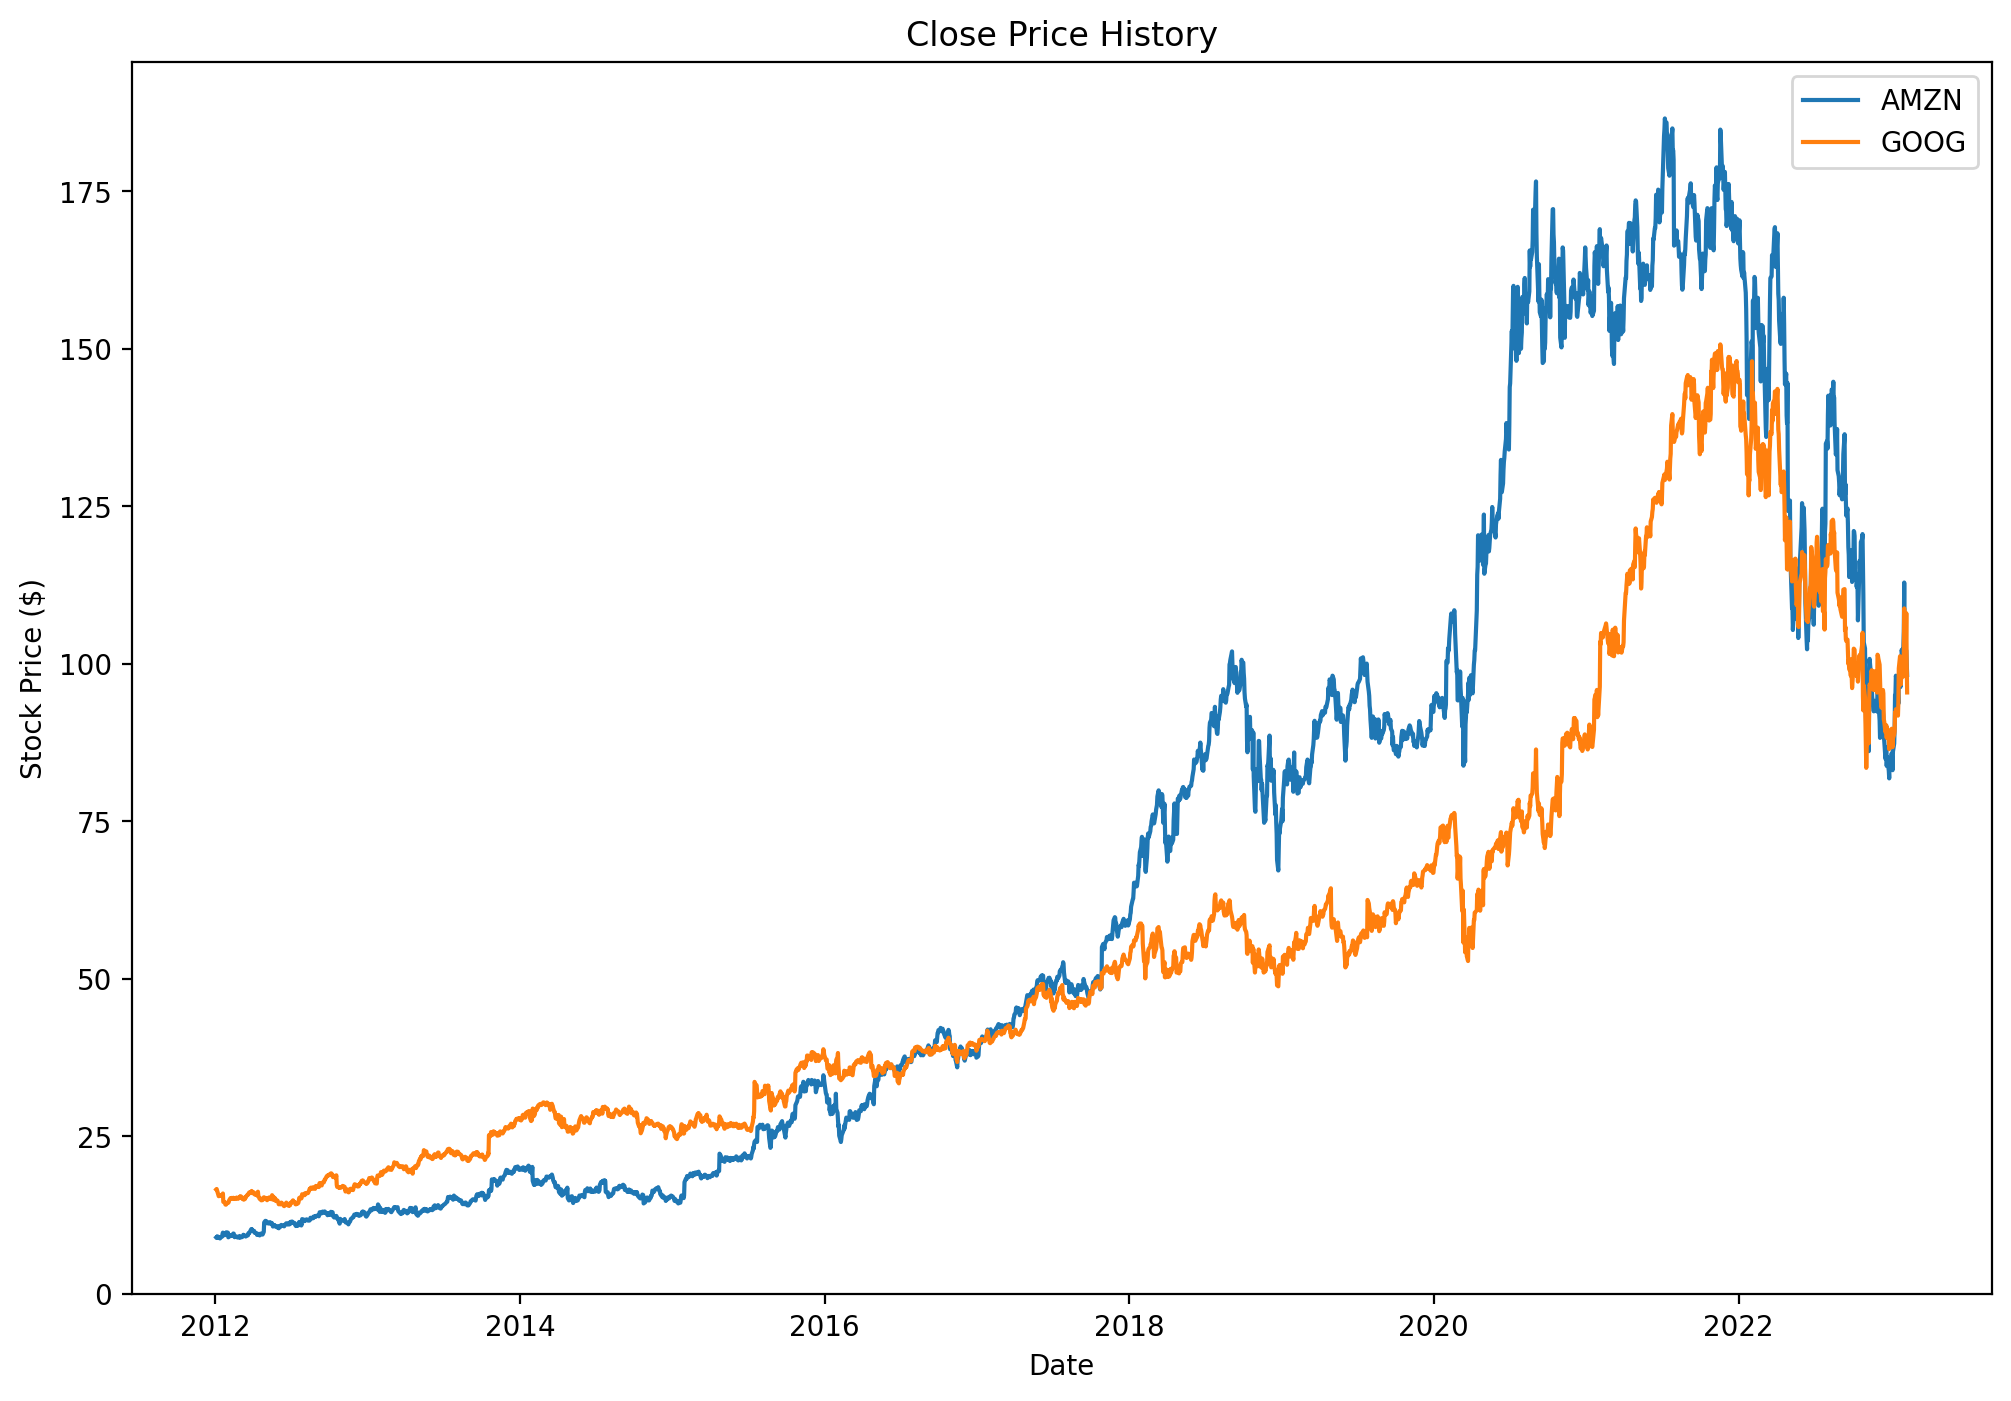

In [157]:
plt.figure(figsize=(12,8))
plt.title('Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date')
plt.ylabel('Stock Price ($)')
plt.legend(['AMZN', 'GOOG'])

In [158]:
data=df['Close']
data.head(20)

,AMZN,GOOG
Date,,
2012-01-03,8.9515,16.573130
2012-01-04,8.8755,16.644611
2012-01-05,8.8805,16.413727
2012-01-06,9.1305,16.189817
2012-01-09,8.9280,15.503389
2012-01-10,8.9670,15.520326
2012-01-11,8.9450,15.590563
2012-01-12,8.7965,15.682219
2012-01-13,8.9210,15.566403


In [159]:
#convert to numpy array
#We use 80 of the data for training
train_pct=0.8  
dataset=data.values
train_data_len=math.ceil(len(dataset)*train_pct)

In [160]:
dataset.shape

(2795, 2)

In [161]:
#Scale the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data=scaler.fit_transform(dataset)
scaled_data.shape

(2795, 2)

The window we use is n_period as input

In [162]:
n_period=60
n_future = 5 # Number of future days to predict

#training dataset
train_data=scaled_data[0:train_data_len]
x_train=[]
y_train=[]

for i in range(n_period, len(train_data) - n_future + 1):
    x_train.append(train_data[i-n_period:i])
    y_train.append(train_data[i: i+n_future,0])

#Converting x_train to a numpy array and reshape

x_train = np.array(x_train).reshape(-1, n_period, 2) #given we have two stocks(AMZN & GOOG)

In [163]:
x_train[0:1]

array([[[0.00087189, 0.01936668],
        [0.00044438, 0.01988927],
        [0.00047251, 0.01820133],
        [0.00187879, 0.01656439],
        [0.0007397 , 0.01154608],
        [0.00095908, 0.0116699 ],
        [0.00083533, 0.01218339],
        [0.        , 0.01285346],
        [0.00070032, 0.01200676],
        [0.0016116 , 0.01266045],
        [0.00379977, 0.01344889],
        [0.00520886, 0.01466158],
        [0.00421884, 0.0049054 ],
        [0.00285756, 0.00481982],
        [0.0031135 , 0.00398405],
        [0.00333851, 0.00190098],
        [0.00489104, 0.00164788],
        [0.00546762, 0.00381107],
        [0.00456197, 0.00339409],
        [0.00520605, 0.00383474],
        [0.00099283, 0.00396584],
        [0.00162847, 0.00474516],
        [0.00330476, 0.00678818],
        [0.00202785, 0.0091116 ],
        [0.00232318, 0.00868915],
        [0.00268599, 0.00924998],
        [0.00254536, 0.00954313],
        [0.00270287, 0.00853256],
        [0.00440447, 0.00967788],
        [0.004

In [164]:
y_train[0:1]

[array([0.00806642, 0.00747578, 0.00622138, 0.0066742 , 0.00507948])]

In [165]:
y_train[:2]

[array([0.00806642, 0.00747578, 0.00622138, 0.0066742 , 0.00507948]),
 array([0.00747578, 0.00622138, 0.0066742 , 0.00507948, 0.00519198])]

In [166]:
#Convert numpy array
x_train, y_train=np.array(x_train), np.array(y_train)

In [167]:
x_train.shape

(2172, 60, 2)

In [168]:
y_train.shape

(2172, 5)

In [169]:
x_train=np.reshape(x_train, (x_train.shape[0], x_train.shape[1],2))
x_train.shape

(2172, 60, 2)

5. Train the model Adam optimization is a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments. loss function is chosen as mean_squared_error'

In [170]:
#Build the LSTM model
model=Sequential()
model.add(LSTM(50,return_sequences=True, input_shape=(x_train.shape[1],2)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))
          

In [171]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [172]:
model.fit(x_train,y_train, batch_size=1, epochs=1)

2172/2172 [==============================] - 17s 6ms/step - loss: 0.0012


In [173]:
#Test

# Extract the portion of the test data for prediction
test_data=scaled_data[train_data_len-60:,:]

# Prepare the test inputs (similar to training)
x_test = []
y_test = []

for i in range(n_period, len(test_data) - n_future + 1):
    x_test.append(test_data[i-n_period:i])
    y_test.append(test_data[i:i+n_future, 0])

# Convert x_test to numpy array and reshape
x_test = np.array(x_test).reshape(-1, n_period, 2)  # Assuming I have 2 features (AMZN, GOOG)

In [174]:
x_test.shape

(555, 60, 2)

In [175]:
scaled_data
scaler.data_max_
scaler.data_min_

array([186.57049561, 150.70899963])

In [176]:
predictions_scaled=model.predict(x_test)

18/18 [==============================] - 1s 4ms/step


In [177]:
#predictions=scaler.inverse_transform(predictions)
predictions=predictions_scaled*(scaler.data_max_[0]-scaler.data_min_[0])+scaler.data_min_[0]

In [178]:
predictions.shape

(555, 1)

In [179]:
#RMSE
rmse=np.sqrt(np.mean(predictions-y_test)**2)
rmse

158.9310282337941

In [180]:
data.max()

AMZN    186.570496
GOOG    150.709000
dtype: float64

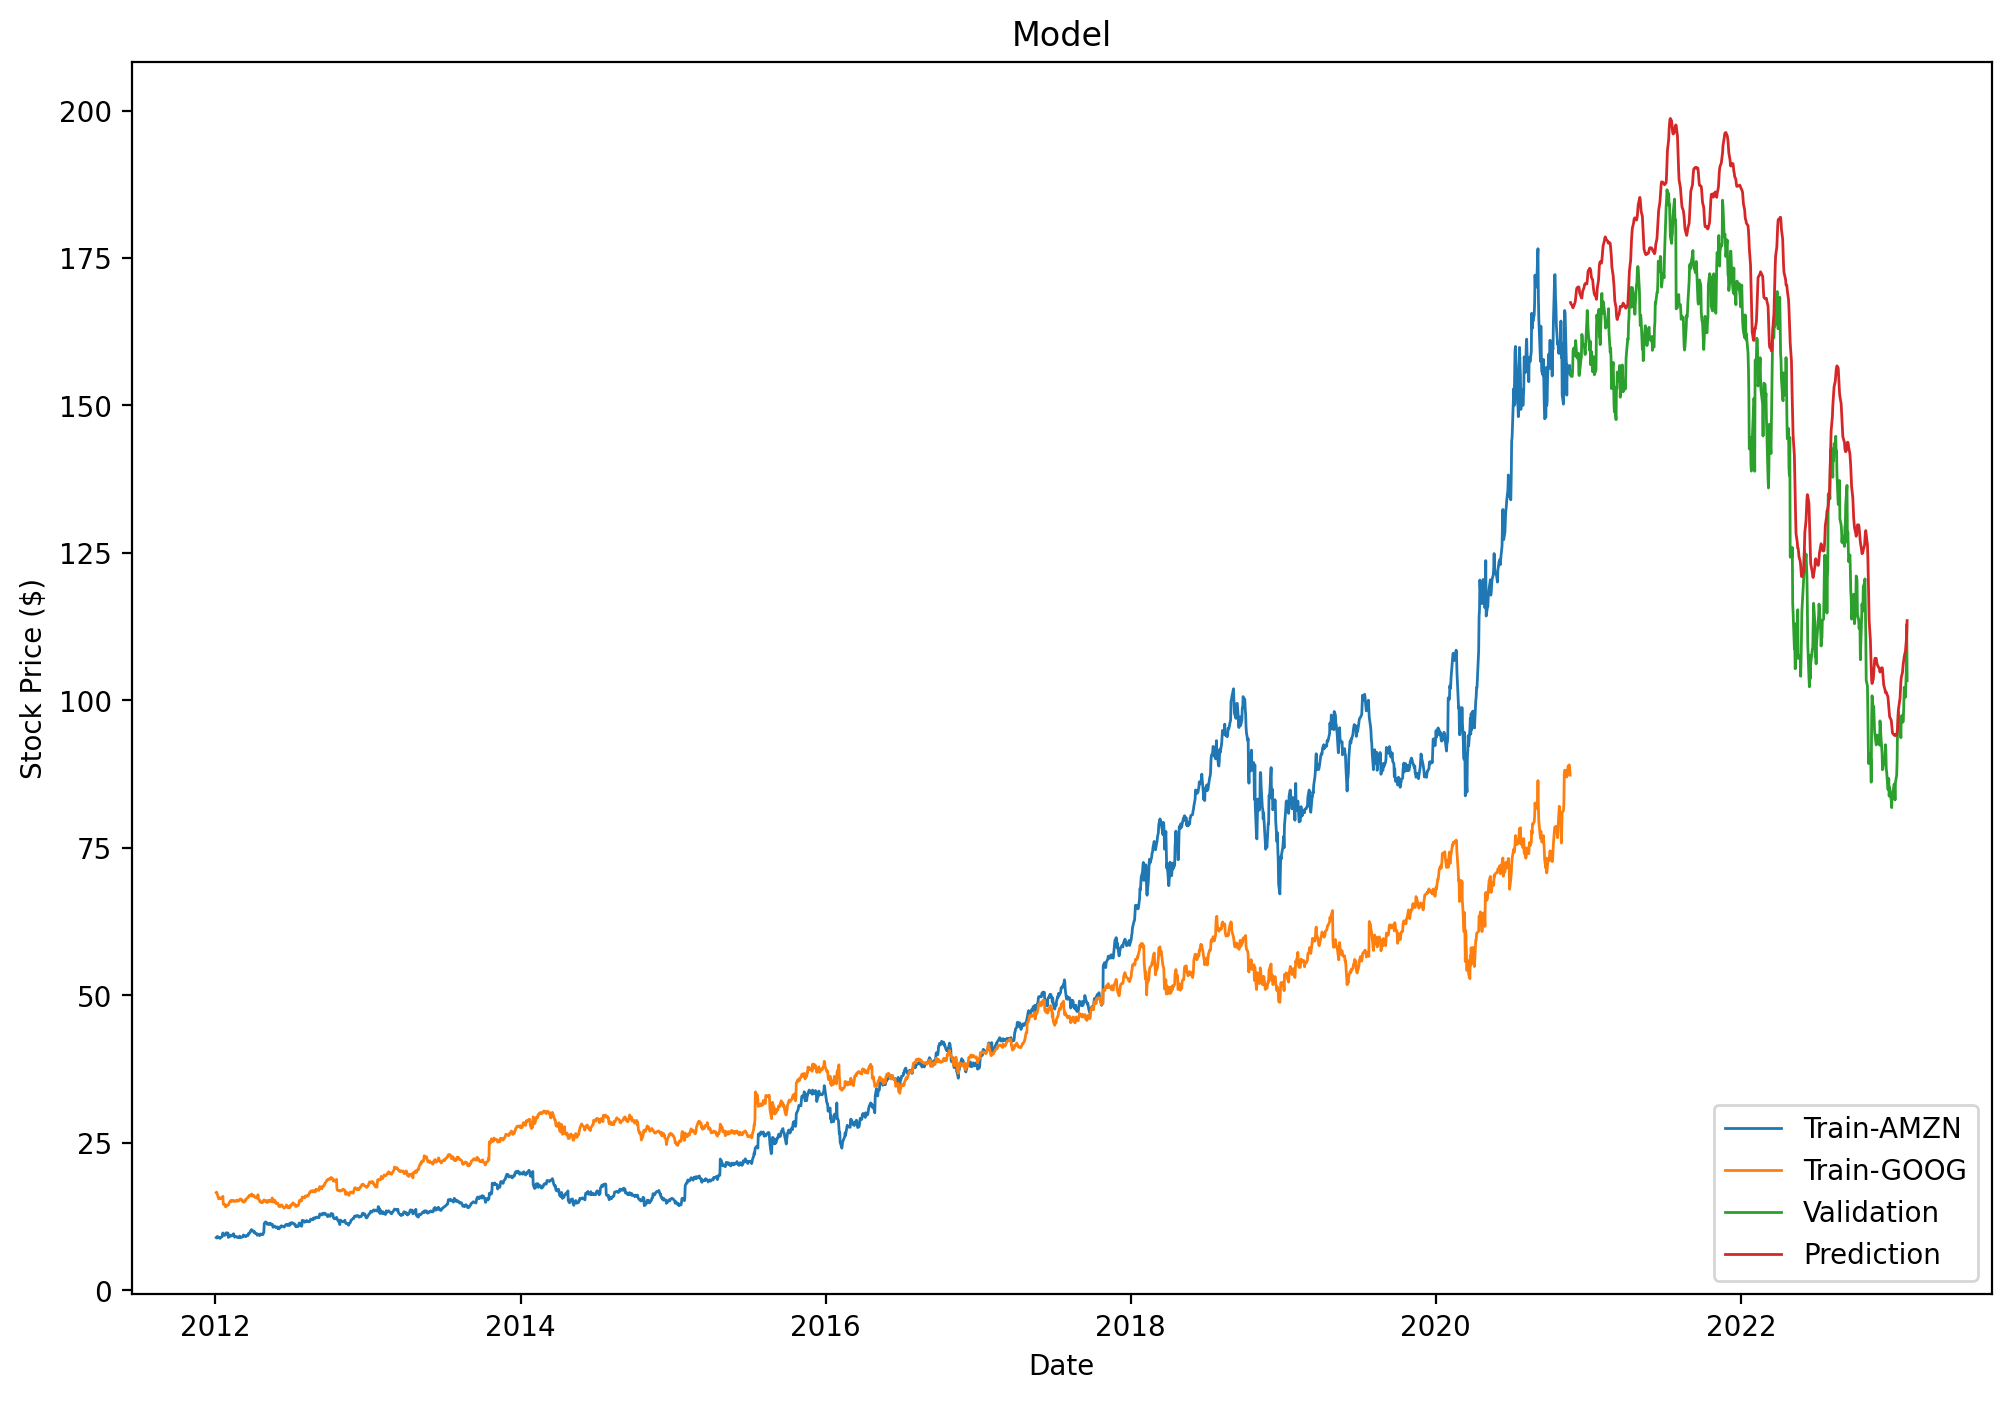

In [181]:
#plot the result
train=data[:train_data_len]
valid=data[train_data_len: train_data_len + len(predictions)]
valid=valid.assign(Predictions=predictions)
plt.figure(figsize=(12,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Stock Price ($)')
plt.plot(train, lw=1)
plt.plot(valid[['AMZN','Predictions']], lw=1)
plt.legend(['Train-AMZN','Train-GOOG', 'Validation', 'Prediction'],loc='lower right')
plt.show()

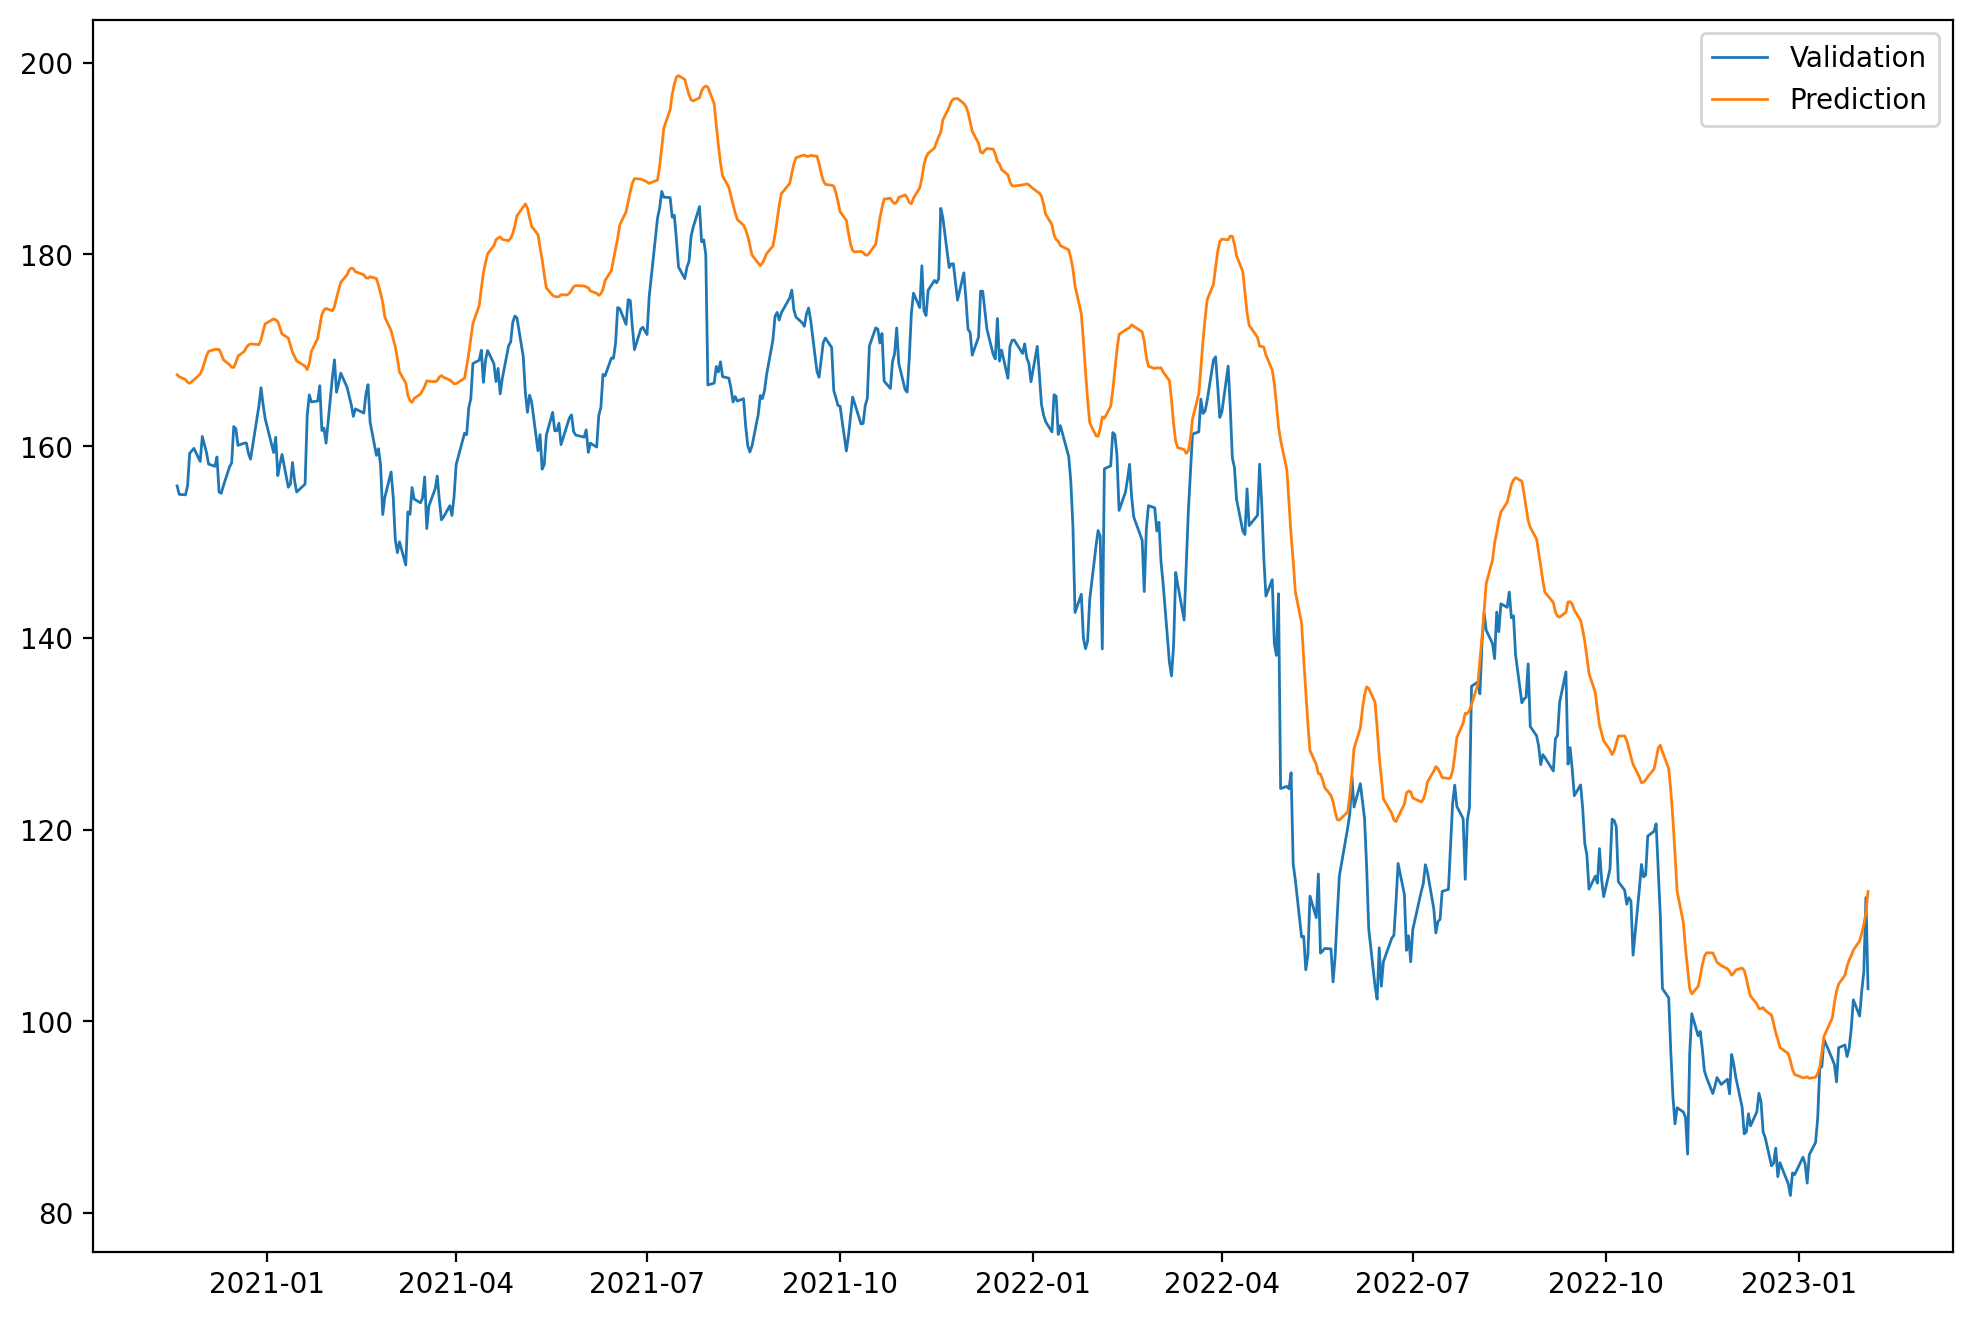

In [182]:
plt.figure(figsize=(12,8))
plt.plot(valid[['AMZN','Predictions']], lw=1)
plt.legend(['Validation', 'Prediction'])

Question: In the example, we use the last 60 day's price to predict the closing price for next day. Modify the program to perform the following task:

a. Use past 60 days price to predict the price in one week (5 days). You can choose any stock. Also use two indices prices for input

b. Use your prediction to generate trading signals for the testing periodd (20% of you dataset): if the predicted price is higher than the current price (you can specify a threshold) , you should buy one share; if it is lower than the current price, you can short one share.

c. Assume that you will always close your position in onw week, caculate your accumaltaed PnL for testing data

d. Repeat. a) - c), adding S&P500 to the features for the prediction (as I explained in the class).

e. Repeat: a)-c), adding S&P 500 and the VIX index to the features for the predcition( as explained in class).




a. Use past 60 days price to predict the price in one week (5 days). You can choose any stock. 

In [183]:
amzn_predicted_prices = predictions[-n_future:, 0]  # Selecting only the AMZN stock predictions
for i, price in enumerate(amzn_predicted_prices, start=1):
    print(f"Day {i}: Predicted price for AMZN stock: {price}")

Day 1: Predicted price for AMZN stock: 108.38990783691406
Day 2: Predicted price for AMZN stock: 109.17144012451172
Day 3: Predicted price for AMZN stock: 110.13077545166016
Day 4: Predicted price for AMZN stock: 111.32612609863281
Day 5: Predicted price for AMZN stock: 113.53559875488281


b. Use your prediction to generate trading signals for the testing periodd (20% of you dataset): if the predicted price is higher than the current price (you can specify a threshold) , you should buy one share; if it is lower than the current price, you can short one share.

ASSUMPTION: WILL BE USING THE AMZN STOCK FOR THIS

In [184]:
# Extract the 'Close' price for the AMZN stock
amzn_prices = df['Close']['AMZN']

# Get the current price
amzn_current_prices = amzn_prices.iloc[-1]

print("Current Price @ AMZN: $", amzn_current_prices)

Current Price @ AMZN: $ 98.23999786376953


In [185]:
threshold = 0.05 #the threshold has been specified as 5% movement up or down # assumption

#getting the last n_future predictions

amzn_predicted_prices = predictions[-n_future:,0]

#replicating current prices to match the length of predicted prices

amzn_current_price = np.full(amzn_predicted_prices.shape, amzn_current_prices)

# Loop through the predicted prices and generate trading signals

for i, amzn_predicted_price in enumerate(amzn_predicted_prices, start=1):

    if np.any(amzn_predicted_price > amzn_current_price * (1 + threshold)):

        # Buy one share

        print("Buy one share on day", i)

    elif np.any (amzn_predicted_price < amzn_current_price * (1 - threshold)):

        # Short one share

        print("Short one share on day", i)

    else:

        # Hold or take no action
        
        print("Hold or take no action on day", i)



Buy one share on day 1
Buy one share on day 2
Buy one share on day 3
Buy one share on day 4
Buy one share on day 5


c. Assume that you will always close your position in one week, calculate your accumaltaed PnL for testing data

In [186]:
# Initialize variables
position = 0

capital = 10000  # Starting capital

pnls = []

# Loop through the testing period

for i, amzn_predicted_price in enumerate(amzn_predicted_prices, start=1):

    # Check trading signal

    if np.any(amzn_predicted_price > amzn_current_price * (1 + threshold)):

        # Buy one share

        if np.any(position == 0):

            shares_to_buy = capital // amzn_current_price

            position += shares_to_buy

            capital -= shares_to_buy * amzn_current_price
            
    elif np.any(amzn_predicted_price < amzn_current_price * (1 - threshold)):
        # Short one share
        if np.any(position > 0):
            shares_to_sell = position
            position -= shares_to_sell
            capital += shares_to_sell * amzn_current_price

    # Calculate PnL for current trade
    pnl = (position * amzn_current_price) - 10000
    pnls.append(pnl)

# Calculate accumulated PnL
accumulated_pnl = np.sum(pnls)

print("Accumulated PnL:", accumulated_pnl)

Accumulated PnL: -1944.0053939819336


d. Repeat. a) - c), adding S&P500 to the features for the prediction (as I explained in the class).

In [187]:
#Starting all over

tickers = ["^GSPC"]

start_date = '2012-01-01'
end_date = '2023-02-10'

df = yf.download(tickers, start=start_date, end=end_date)

sp500_prices = df[["Close","Adj Close"]]
sp500_prices.head()

[*********************100%***********************]  1 of 1 completed


,Close,Adj Close
Date,,
2012-01-03,1277.060059,1277.060059
2012-01-04,1277.300049,1277.300049
2012-01-05,1281.060059,1281.060059
2012-01-06,1277.810059,1277.810059
2012-01-09,1280.699951,1280.699951


In [188]:
#convert to numpy array
#We use 80 of the data for training
train_pct=0.8  
dataset= sp500_prices.values
train_data_len=math.ceil(len(dataset)*train_pct)

In [189]:
dataset.shape

#scaling the data

scaler = MinMaxScaler(feature_range =(0,1))

scaled_data= scaler.fit_transform(dataset)

scaled_data.shape

(2795, 2)

In [190]:
n_period = 60
n_future = 5  # Number of future days to predict

# Training dataset
train_data = scaled_data[0:train_data_len]
x_train = []
y_train = []

for i in range(n_period, len(train_data) - n_future + 1):
    x_train.append(train_data[i - n_period:i, :])  # Adjust the number of columns based on the number of features
    y_train.append(train_data[i:i + n_future, 0])  # Use the appropriate column index for the target variable

# Convert x_train to numpy array and reshape
x_train = np.array(x_train).reshape(-1, n_period, 2)  # Replace num_features with the actual number of features

In [191]:
x_train

array([[[0.00000000e+00, 0.00000000e+00],
        [6.81887298e-05, 6.81887298e-05],
        [1.13652507e-03, 1.13652507e-03],
        ...,
        [3.96220915e-02, 3.96220915e-02],
        [3.84884106e-02, 3.84884106e-02],
        [3.65051798e-02, 3.65051798e-02]],

       [[6.81887298e-05, 6.81887298e-05],
        [1.13652507e-03, 1.13652507e-03],
        [2.13098451e-04, 2.13098451e-04],
        ...,
        [3.84884106e-02, 3.84884106e-02],
        [3.65051798e-02, 3.65051798e-02],
        [3.58630404e-02, 3.58630404e-02]],

       [[1.13652507e-03, 1.13652507e-03],
        [2.13098451e-04, 2.13098451e-04],
        [1.03420730e-03, 1.03420730e-03],
        ...,
        [3.65051798e-02, 3.65051798e-02],
        [3.58630404e-02, 3.58630404e-02],
        [3.73376650e-02, 3.73376650e-02]],

       ...,

       [[5.98076412e-01, 5.98076412e-01],
        [6.00289806e-01, 6.00289806e-01],
        [5.96047745e-01, 5.96047745e-01],
        ...,
        [6.34575904e-01, 6.34575904e-01],
     

In [192]:
#Converting into numpy array

x_train, y_train = np.array(x_train), np.array(y_train)

In [194]:
#Build the LSTM model
model=Sequential()
model.add(LSTM(50,return_sequences=True, input_shape=(x_train.shape[1],2)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train,y_train, batch_size=1, epochs=1)

2172/2172 [==============================] - 16s 6ms/step - loss: 0.0010


In [195]:
# Test data
test_data = scaled_data[train_data_len - n_period:, :]  # Extract the portion of the test data for prediction

# Prepare the test inputs (similar to training)
x_test = []
y_test = []

for i in range(n_period, len(test_data) - n_future + 1):
    x_test.append(test_data[i - n_period:i, :])  # Adjust the number of columns based on the number of features
    y_test.append(test_data[i:i + n_future, 0])  # Use the appropriate column index for the target variable

# Convert x_test to numpy array and reshape
x_test = np.array(x_test).reshape(-1, n_period,2)  

In [196]:
predictions_scaled=model.predict(x_test)

#predictions=scaler.inverse_transform(predictions)
predictions=predictions_scaled*(scaler.data_max_[0]-scaler.data_min_[0])+scaler.data_min_[0]

18/18 [==============================] - 1s 4ms/step


In [197]:
predictions.shape

(555, 1)

In [198]:
#RMSE
rmse=np.sqrt(np.mean(predictions-y_test)**2)
rmse

3954.8679317256565

In [199]:
sp500_prices.max()

Close        4796.560059
Adj Close    4796.560059
dtype: float64

In [200]:
# Download stock data
df = yf.download("^GSPC", start="2012-01-01", end="2023-02-10")

# Extract the 'Close' price for the chosen stock
prices = df['Close']

# Split the data into training and testing sets
train_data_len = math.ceil(len(prices) * 0.8)
train_data = prices[:train_data_len]
test_data = prices[train_data_len:]

# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
train_data = scaler.fit_transform(train_data.values.reshape(-1, 1))
test_data = scaler.transform(test_data.values.reshape(-1, 1))

# Define constants and variables
n_period = 60
n_future = 5
threshold = 0.05
position = 0
capital = 10000
pnls = []

# Prepare the training data
x_train = []
y_train = []
for i in range(n_period, len(train_data) - n_future + 1):
    x_train.append(train_data[i - n_period:i, 0])
    y_train.append(train_data[i:i + n_future, 0])

# Convert to numpy arrays
x_train = np.array(x_train)
y_train = np.array(y_train)

# Reshape the input data for LSTM
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(n_period, 1)))
model.add(LSTM(units=50))
model.add(Dense(units=n_future))
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(x_train, y_train, epochs=10, batch_size=32)

# Prepare the testing data
x_test = []
y_test = []
for i in range(n_period, len(test_data) - n_future + 1):
    x_test.append(test_data[i - n_period:i, 0])
    y_test.append(test_data[i:i + n_future, 0])

# Convert to numpy arrays
x_test = np.array(x_test)
y_test = np.array(y_test)

# Reshape the input data for LSTM
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# Make predictions for the testing data
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)


[*********************100%***********************]  1 of 1 completed
Epoch 1/10
68/68 [==============================] - 5s 8ms/step - loss: 0.0261
Epoch 2/10
68/68 [==============================] - 0s 6ms/step - loss: 0.0011
Epoch 3/10
68/68 [==============================] - 0s 6ms/step - loss: 0.0011
Epoch 4/10
68/68 [==============================] - 0s 7ms/step - loss: 0.0010
Epoch 5/10
68/68 [==============================] - 0s 6ms/step - loss: 0.0010
Epoch 6/10
68/68 [==============================] - 0s 6ms/step - loss: 9.4194e-04
Epoch 7/10
68/68 [==============================] - 0s 6ms/step - loss: 9.2228e-04
Epoch 8/10
68/68 [==============================] - 0s 6ms/step - loss: 8.5642e-04
Epoch 9/10
68/68 [==============================] - 0s 6ms/step - loss: 8.2900e-04
Epoch 10/10
16/16 [==============================] - 1s 3ms/step


In [201]:
predicted_prices = predictions[-n_future:]

print(predicted_prices)

[[3870.1592 3868.1287 3842.2568 3850.3264 3872.7249]
 [3878.2527 3875.884  3849.919  3858.168  3881.2693]
 [3887.5593 3885.0747 3858.615  3867.0547 3890.4084]
 [3899.1494 3896.5842 3869.1277 3877.8628 3901.0488]
 [3914.754  3912.313  3882.911  3892.2783 3914.6555]]


In [202]:
current_price = df['Close'].iloc[-1]
print("Current Price:", current_price)

Current Price: 4081.5


In [203]:
threshold = 0.01  # Change the threshold value as needed 

# Get the last n_future predictions
predicted_prices = predictions[-n_future:]

# Replicate current_price to match the length of predicted_prices
current_prices = np.full(predicted_prices.shape, current_price)

# Loop through the predicted prices and generate trading signals
for i, predicted_price in enumerate(predicted_prices):
    if predicted_price[0] > current_prices[i][0] * (1 + threshold):
        # Buy one share
        print("Buy one share on day", i)
    elif predicted_price[0] < current_prices[i][0] * (1 - threshold):
        # Short one share
        print("Short one share on day", i)
    else:
        # Hold or take no action
        print("Hold or take no action on day", i)

Short one share on day 0
Short one share on day 1
Short one share on day 2
Short one share on day 3
Short one share on day 4


In [204]:
# Initialize variables
position = 0
capital = 10000  # Starting capital
pnls = []

# Loop through the predicted prices and generate trading signals
for i, predicted_price in enumerate(predicted_prices):
    if predicted_price[0] > current_prices[i][0] * (1 + threshold):
        # Buy one share
        if position == 0:
            shares_to_buy = capital // current_prices[i][0]
            position += shares_to_buy
            capital -= shares_to_buy * current_prices[i][0]
    elif predicted_price[0] < current_prices[i][0] * (1 - threshold):
        # Short one share
        if position > 0:
            shares_to_sell = position
            position -= shares_to_sell
            capital += shares_to_sell * current_prices[i][0]

    # Calculate PnL for current trade
    pnl = (position * current_prices[i][0]) - 10000
    pnls.append(pnl)

# Calculate accumulated PnL
accumulated_pnl = sum(pnls)

print("Accumulated PnL:", accumulated_pnl)

Accumulated PnL: -50000.0


e. Repeat a)-c), adding S&p500 and the VIX index to the features for the prediction. 

In [205]:
# Download S&P 500 data
sp500_df = yf.download('^GSPC', start='2012-01-01', end='2023-02-10')
sp500_prices = sp500_df['Close']

# Download VIX index data
vix_df = yf.download('^VIX', start='2012-01-01', end='2023-02-10')
vix_prices = vix_df['Close']


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [206]:
# Merge the stock data, S&P 500 data, and VIX index data
merged_data = pd.concat([prices, sp500_prices, vix_prices], axis=1)
merged_data.columns = ['Stock', 'S&P 500', 'VIX Index']

In [207]:
train_data_len = math.ceil(len(merged_data) * 0.8)
train_data = merged_data[:train_data_len]
test_data = merged_data[train_data_len:]


In [208]:
scaler = MinMaxScaler(feature_range=(0, 1))
train_data = scaler.fit_transform(train_data.values)
test_data = scaler.transform(test_data.values)

In [209]:
n_period = 60
n_future = 5

# Prepare the training data
x_train = []
y_train = []
for i in range(n_period, len(train_data) - n_future + 1):
    x_train.append(train_data[i - n_period:i, :])
    y_train.append(train_data[i:i + n_future, 0])

# Convert to numpy arrays
x_train = np.array(x_train)
y_train = np.array(y_train)

# Reshape the input data for LSTM
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], x_train.shape[2]))

# Prepare the testing data
x_test = []
y_test = []
for i in range(n_period, len(test_data) - n_future + 1):
    x_test.append(test_data[i - n_period:i, :])
    y_test.append(test_data[i:i + n_future, 0])

# Convert to numpy arrays
x_test = np.array(x_test)
y_test = np.array(y_test)

# Reshape the input data for LSTM
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], x_test.shape[2]))


In [211]:

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(n_period, x_train.shape[2])))
model.add(LSTM(units=50))
model.add(Dense(units=n_future))
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(x_train, y_train, epochs=10, batch_size=32)

Epoch 1/10
68/68 [==============================] - 4s 8ms/step - loss: 0.0203
Epoch 2/10
68/68 [==============================] - 0s 6ms/step - loss: 0.0011
Epoch 3/10
68/68 [==============================] - 0s 6ms/step - loss: 9.3153e-04
Epoch 4/10
68/68 [==============================] - 0s 6ms/step - loss: 7.9432e-04
Epoch 5/10
68/68 [==============================] - 0s 6ms/step - loss: 7.3707e-04
Epoch 6/10
68/68 [==============================] - 0s 6ms/step - loss: 7.0345e-04
Epoch 7/10
68/68 [==============================] - 0s 6ms/step - loss: 7.1860e-04
Epoch 8/10
68/68 [==============================] - 0s 6ms/step - loss: 5.9778e-04
Epoch 9/10
68/68 [==============================] - 0s 7ms/step - loss: 6.3853e-04
Epoch 10/10
68/68 [==============================] - 0s 7ms/step - loss: 5.6388e-04


In [216]:
# Make predictions for the testing data
predictions = model.predict(x_test)
min_price = prices.min()
max_price = prices.max()
scaled_predictions = (predictions * (max_price - min_price)) + min_price
predicted_prices = scaled_predictions[:, -1]


16/16 [==============================] - 0s 5ms/step


Part **a**

In [219]:
for i, price in enumerate(predicted_prices[:5]):
    day = i + 1
    print(f"Day {day}: Predicted price on day is {price:.2f}")


Day 1: Predicted price on day is 5109.61
Day 2: Predicted price on day is 5121.49
Day 3: Predicted price on day is 5129.45
Day 4: Predicted price on day is 5128.34
Day 5: Predicted price on day is 5124.34


Part b

In [222]:
threshold = 0.05  # Set the threshold value as needed

# Get the last n_future predictions
predicted_prices = predictions[-n_future:]

# Replicate current_price to match the length of predicted_prices
current_prices = np.full(predicted_prices.shape, current_price)

# Loop through the predicted prices and generate trading signals
for i, predicted_price in enumerate(predicted_prices):
    if np.all(predicted_price > current_prices[i] * (1 + threshold)):
        # Buy one share
        print("Buy one share on day", i)
    elif np.all(predicted_price < current_prices[i] * (1 - threshold)):
        # Short one share
        print("Short one share on day", i)
    else:
        # Hold or take no action
        print("Hold or take no action on day", i)


Short one share on day 0
Short one share on day 1
Short one share on day 2
Short one share on day 3
Short one share on day 4


Part c

In [225]:
# Initialize variables
position = 0
capital = 10000  # Starting capital
pnls = []

# Loop through the predicted prices and generate trading signals
for i, predicted_price in enumerate(predicted_prices):
    if np.all(predicted_price > current_prices[i] * (1 + threshold)):
        # Buy one share
        if position == 0:
            shares_to_buy = capital // current_prices[i]
            position += shares_to_buy
            capital -= shares_to_buy * current_prices[i]
    elif np.all(predicted_price < current_prices[i] * (1 - threshold)):
        # Short one share
        if position > 0:
            shares_to_sell = position
            position -= shares_to_sell
            capital += shares_to_sell * current_prices[i]

# Calculate P&L for the week
pnl = (position * current_prices[-1]) - 10000
pnls.append(pnl)

# Calculate accumulated P&L
accumulated_pnl = sum(pnls)

print("Accumulated P&L for the week:", accumulated_pnl)



Accumulated P&L for the week: [-10000. -10000. -10000. -10000. -10000.]
